[*********************100%***********************]  1 of 1 completed
Model is not converging.  Current: 20505.439240821124 is not greater than 20505.443745915145. Delta is -0.0045050940207147505


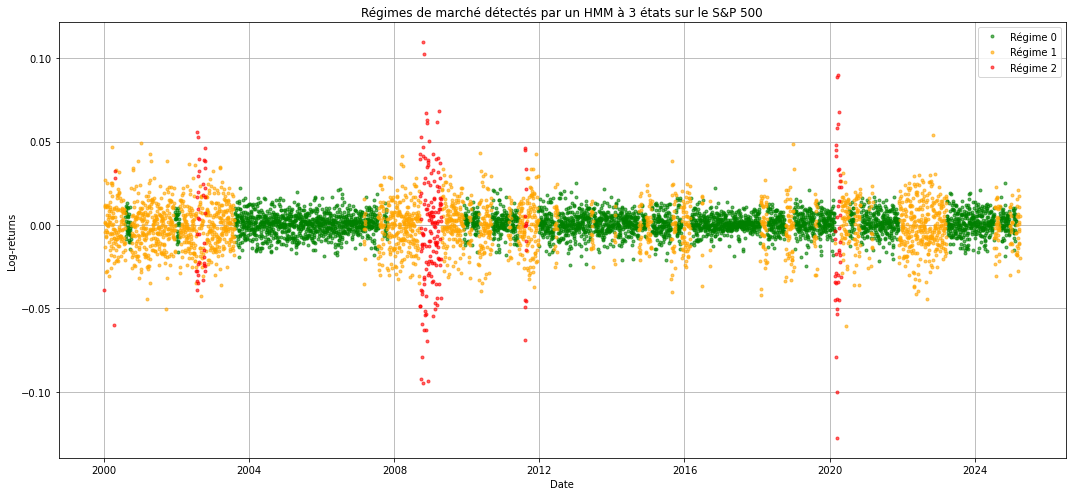

Statistiques par régime détecté (classés par volatilité croissante) :

Régime 0 : Moyenne = 0.00088, Variance = 0.00004
Régime 1 : Moyenne = -0.00056, Variance = 0.00020
Régime 2 : Moyenne = -0.00250, Variance = 0.00134


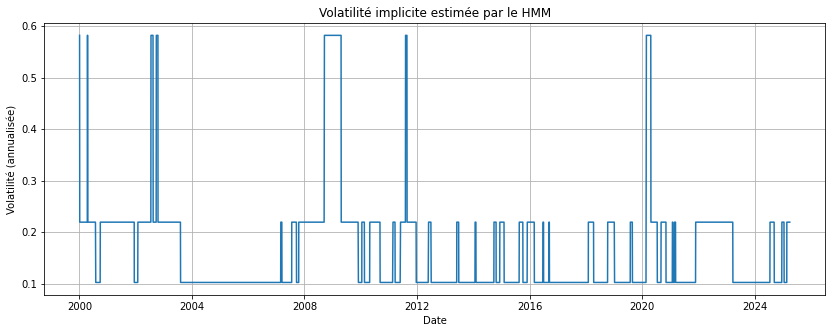

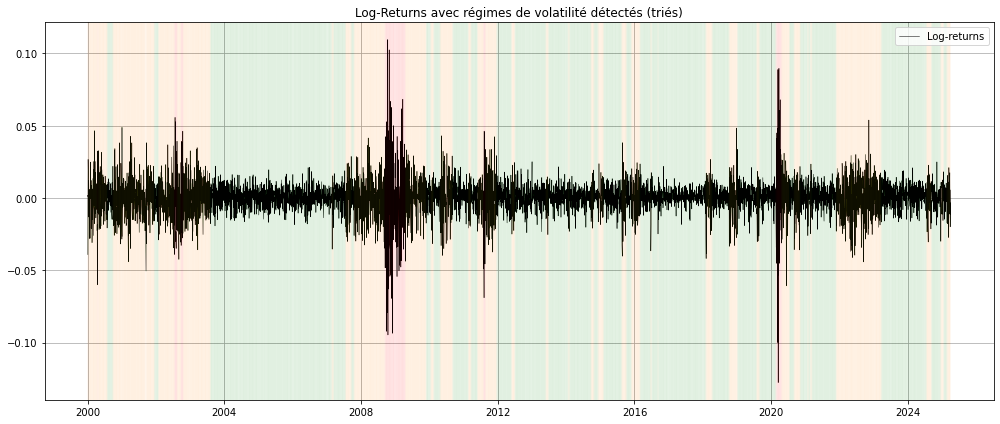


Durée moyenne par régime :
Régime 0 : 1.44 jours
Régime 1 : 0.59 jours
Régime 2 : 0.04 jours


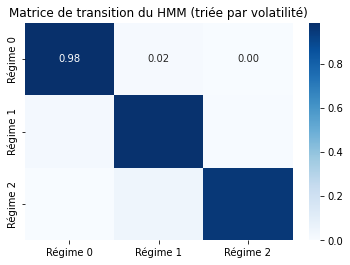

In [45]:
# 📦 Imports
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import seaborn as sns

# ✅ Étape 1 - Récupération des données
data = yf.download('^GSPC', start='2000-01-01', end='2025-04-01')

# ✅ Étape 2 - Calcul des log-returns
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data = data.dropna()

# ✅ Étape 3 - Préparation des données pour le modèle
returns = data['Log_Returns'].values.reshape(-1, 1)

# ✅ Étape 4 - HMM à 3 états
model = GaussianHMM(n_components=3, covariance_type='full', n_iter=1000)
model.fit(returns)

# ✅ Étape 5 - Prédiction des états cachés
hidden_states = model.predict(returns)

# ✅ Étape 5 bis - Reclasser les régimes par ordre de volatilité
state_variances = [np.var(returns[hidden_states == i]) for i in range(3)]
sorted_states = np.argsort(state_variances)  # indices des régimes triés
remap = {old: new for new, old in enumerate(sorted_states)}
remapped_states = np.vectorize(remap.get)(hidden_states)
data['Hidden_State'] = remapped_states

# ✅ Étape 6 - Visualisation des régimes
colors = ['green', 'orange', 'red']  # 0 = calme, 2 = crise
plt.figure(figsize=(15, 7))
for i in range(3):
    state = (data['Hidden_State'] == i)
    plt.plot(data.index[state], data['Log_Returns'][state], '.', label=f"Régime {i}", color=colors[i], alpha=0.6)

plt.title("Régimes de marché détectés par un HMM à 3 états sur le S&P 500")
plt.xlabel("Date")
plt.ylabel("Log-returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Étape 7 - Statistiques de chaque régime
print("Statistiques par régime détecté (classés par volatilité croissante) :\n")
for i in range(3):
    mask = (data['Hidden_State'] == i)
    mean = data['Log_Returns'][mask].mean()
    var = data['Log_Returns'][mask].var()
    print(f"Régime {i} : Moyenne = {mean:.5f}, Variance = {var:.5f}")

# ✅ Volatilité implicite estimée
data['Variance_estimee'] = [model.covars_[hidden_states[i]][0][0] for i in range(len(hidden_states))]
plt.figure(figsize=(14, 5))
plt.plot(data.index, np.sqrt(data['Variance_estimee']) * np.sqrt(252))  # Annualisée
plt.title("Volatilité implicite estimée par le HMM")
plt.ylabel("Volatilité (annualisée)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

# ✅ Bande verticale colorée
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data.index, data['Log_Returns'], color='black', lw=0.5, label="Log-returns")
colors_map = {0: 'green', 1: 'orange', 2: 'red'}
hidden_colors = data['Hidden_State'].map(colors_map)
for i in range(len(data)):
    ax.axvline(data.index[i], color=hidden_colors[i], alpha=0.01)

ax.set_title("Log-Returns avec régimes de volatilité détectés (triés)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Durée moyenne par régime
print("\nDurée moyenne par régime :")
for i in range(3):
    durations = data['Hidden_State'].eq(i).astype(int).groupby((data['Hidden_State'] != i).cumsum()).sum()
    print(f"Régime {i} : {durations.mean():.2f} jours")

# ✅ Matrice de transition
# On réorganise les lignes/colonnes de la matrice pour correspondre au nouveau mapping
trans_mat_sorted = model.transmat_[sorted_states, :][:, sorted_states]
trans_df = pd.DataFrame(trans_mat_sorted, columns=[f'Régime {i}' for i in range(3)], index=[f'Régime {i}' for i in range(3)])
sns.heatmap(trans_df, annot=True, cmap='Blues', fmt=".2f")
plt.title("Matrice de transition du HMM (triée par volatilité)")
plt.show()



 Prévision pour demain :
→ Probabilité d'être en Régime 0 : 2.23%
→ Probabilité d'être en Régime 1 : 0.44%
→ Probabilité d'être en Régime 2 : 97.34%

 Régime le plus probable demain : Régime 2


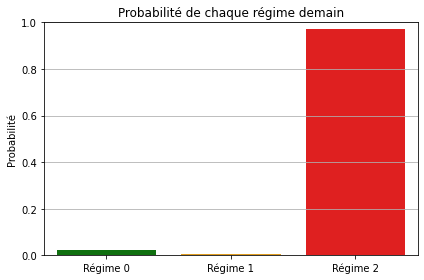

In [46]:
# Dernier état estimé
last_state = hidden_states[-1]

# Matrice de transition
A = model.transmat_

# Probabilité d'être dans chaque état demain
proba_next = A[last_state]

# Affichage
print("\n Prévision pour demain :")
for i, p in enumerate(proba_next):
    print(f"→ Probabilité d'être en Régime {i} : {p:.2%}")

# État le plus probable
regime_prevu = np.argmax(proba_next)
print(f"\n Régime le plus probable demain : Régime {regime_prevu}")

import seaborn as sns

plt.figure(figsize=(6, 4))
sns.barplot(x=[f"Régime {i}" for i in range(3)], y=proba_next, palette=colors)
plt.title("Probabilité de chaque régime demain")
plt.ylim(0, 1)
plt.ylabel("Probabilité")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


# STATIC HMM

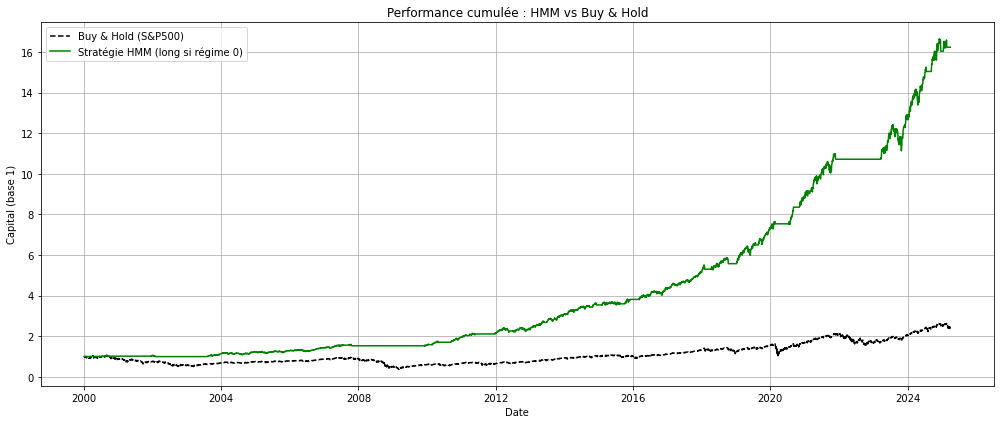

📊 Résumé des performances annualisées :
Stratégie HMM : Rendement = 11.40%, Volatilité = 8.13%, Sharpe = 1.40
Buy & Hold     : Rendement = 5.36%, Volatilité = 19.39%, Sharpe = 0.28


In [47]:
# On prédit le régime du lendemain pour chaque jour
predicted_next = []

for t in range(len(hidden_states) - 1):
    current_state = hidden_states[t]
    probs = model.transmat_[current_state]
    predicted_state = np.argmax(probs)
    predicted_next.append(predicted_state)

# Décalage pour aligner avec les returns de t+1
predicted_next = [np.nan] + predicted_next  # Ajout d'un NaN pour que ça fasse la même longueur
data['Predicted_Regime'] = predicted_next

# Stratégie : long uniquement si régime prédit = 0
data['Strategy_Returns'] = data['Log_Returns'] * (data['Predicted_Regime'] == 0)

# Cumul des rendements
data['Cumulative_Strategy'] = (1 + data['Strategy_Returns']).cumprod()
data['Cumulative_Market'] = (1 + data['Log_Returns']).cumprod()

# 📊 Visualisation de la perf
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Cumulative_Market'], label='Buy & Hold (S&P500)', color='black', linestyle='--')
plt.plot(data.index, data['Cumulative_Strategy'], label='Stratégie HMM (long si régime 0)', color='green')
plt.title("Performance cumulée : HMM vs Buy & Hold")
plt.ylabel("Capital (base 1)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

perf = data[['Strategy_Returns', 'Log_Returns']].dropna()
mean_strategy = perf['Strategy_Returns'].mean() * 252
mean_market = perf['Log_Returns'].mean() * 252
vol_strategy = perf['Strategy_Returns'].std() * np.sqrt(252)
vol_market = perf['Log_Returns'].std() * np.sqrt(252)
sharpe_strategy = mean_strategy / vol_strategy
sharpe_market = mean_market / vol_market

print("📊 Résumé des performances annualisées :")
print(f"Stratégie HMM : Rendement = {mean_strategy:.2%}, Volatilité = {vol_strategy:.2%}, Sharpe = {sharpe_strategy:.2f}")
print(f"Buy & Hold     : Rendement = {mean_market:.2%}, Volatilité = {vol_market:.2%}, Sharpe = {sharpe_market:.2f}")



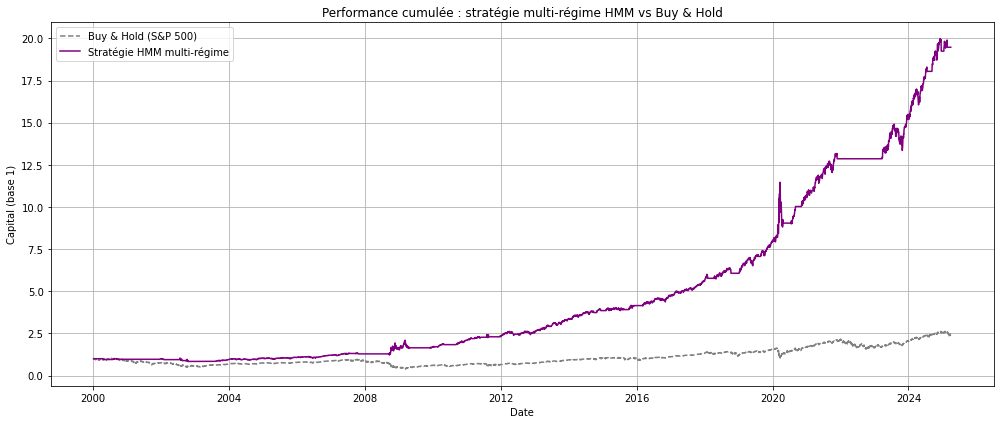


📊 Performances annualisées :
Stratégie Multi-régime : Rendement = 12.75%, Volatilité = 0.14, Sharpe = 0.92
Buy & Hold             : Rendement = 5.51%, Volatilité = 0.19, Sharpe = 0.28


In [50]:
# ✅ Prédiction du régime de demain pour chaque jour (multi-régime)
predicted_next = []

for t in range(len(hidden_states) - 1):
    current_state = hidden_states[t]
    next_probs = model.transmat_[current_state]
    next_state_pred = np.argmax(next_probs)
    # Re-mappe selon l’ordre trié
    next_state_remapped = remap[next_state_pred]
    predicted_next.append(next_state_remapped)

predicted_next = [np.nan] + predicted_next  # alignement temporel
data['Predicted_Regime'] = predicted_next

# ✅ Signal de position : +1 = long (régime 0), 0 = cash (régime 1), -1 = short (régime 2)
position = data['Predicted_Regime'].map({0: 1, 1: 0, 2: -1})
data['Position'] = position

# ✅ Calcul des rendements de la stratégie
data['Strategy_Multi'] = data['Log_Returns'] * data['Position']
data['Cumulative_Multi'] = (1 + data['Strategy_Multi']).cumprod()
data['Cumulative_BH'] = (1 + data['Log_Returns']).cumprod()

# ✅ Visualisation de la perf
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Cumulative_BH'], label='Buy & Hold (S&P 500)', linestyle='--', color='gray')
plt.plot(data.index, data['Cumulative_Multi'], label='Stratégie HMM multi-régime', color='purple')
plt.title("Performance cumulée : stratégie multi-régime HMM vs Buy & Hold")
plt.ylabel("Capital (base 1)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Résumé des performances annualisées
perf = data[['Strategy_Multi', 'Log_Returns']].dropna()

mean_multi = perf['Strategy_Multi'].mean() * 252
vol_multi = perf['Strategy_Multi'].std() * np.sqrt(252)
sharpe_multi = mean_multi / vol_multi

mean_bh = perf['Log_Returns'].mean() * 252
vol_bh = perf['Log_Returns'].std() * np.sqrt(252)
sharpe_bh = mean_bh / vol_bh

print("\n📊 Performances annualisées :")
print(f"Stratégie Multi-régime : Rendement = {mean_multi:.2%}, Volatilité = {vol_multi:.2f}, Sharpe = {sharpe_multi:.2f}")
print(f"Buy & Hold             : Rendement = {mean_bh:.2%}, Volatilité = {vol_bh:.2f}, Sharpe = {sharpe_bh:.2f}")


In [51]:
pip install streamlit yfinance hmmlearn matplotlib seaborn numpy pandas



SyntaxError: invalid syntax (4174679986.py, line 1)

## SV HMM STATIC 



[*********************100%***********************]  1 of 1 completed


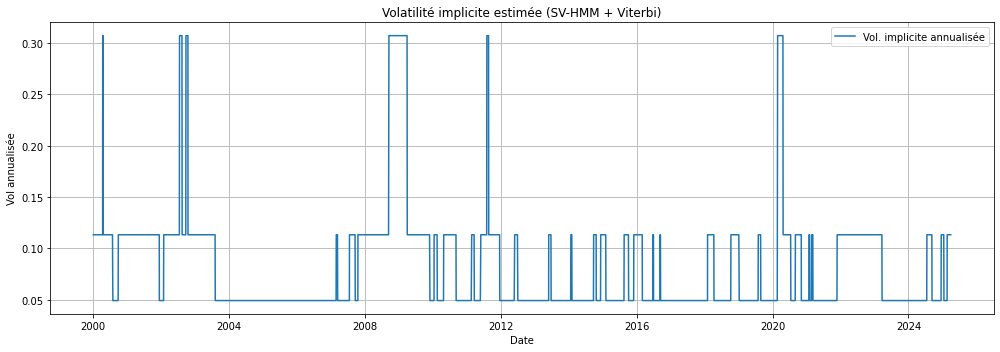

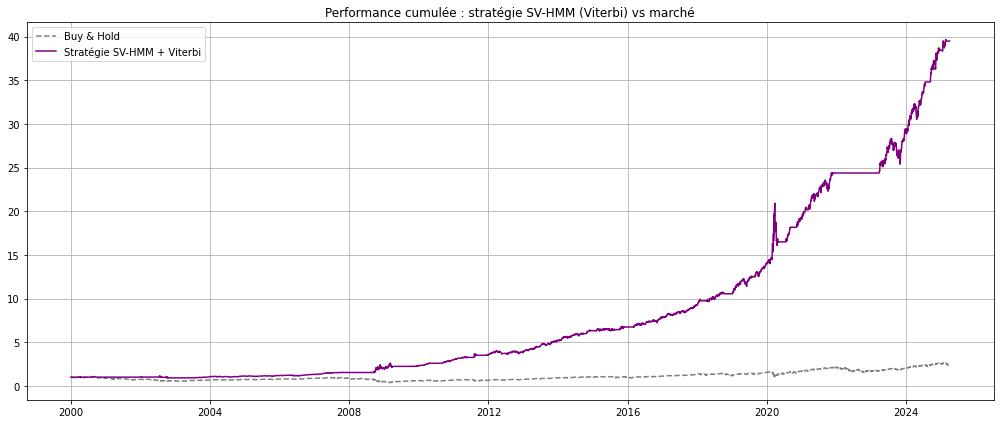

📊 Performances annualisées :
Stratégie SV-HMM : Rendement = 15.54%, Vol = 0.14, Sharpe = 1.13
Buy & Hold      : Rendement = 5.36%, Vol = 0.19, Sharpe = 0.28


/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_36578/2729300263.py:113: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


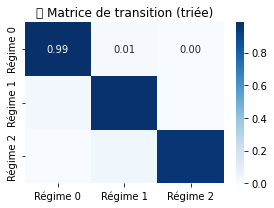


⏱️ Durée moyenne par régime :
Régime 0 : 1.44 jours
Régime 1 : 0.59 jours
Régime 2 : 0.04 jours

📊 Statistiques par régime (log-returns) :
Régime 0 : Moyenne = 0.00088, Variance = 0.00004, Vol. annualisée = 10.19%
Régime 1 : Moyenne = -0.00055, Variance = 0.00020, Vol. annualisée = 22.30%
Régime 2 : Moyenne = -0.00273, Variance = 0.00139, Vol. annualisée = 59.16%


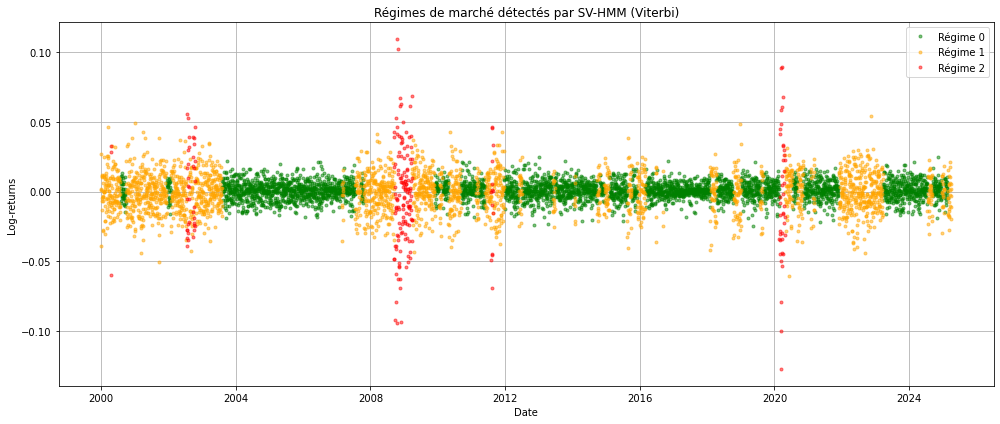

In [6]:
# 📦 Imports
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.linear_model import LinearRegression
import seaborn as sns

# 📥 1. Données
data = yf.download('^GSPC', start='2000-01-01', end='2025-04-01')
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)
returns = data['Log_Returns'].values.reshape(-1, 1)

# 🤖 2. HMM à 3 régimes + Viterbi
model = GaussianHMM(n_components=3, covariance_type='full', n_iter=1000)
model.fit(returns)
viterbi_states = model.predict(returns)  # Viterbi path

# 🔢 3. Trier les régimes par volatilité
variances = [np.var(returns[viterbi_states == i]) for i in range(3)]
sorted_states = np.argsort(variances)
remap = {old: new for new, old in enumerate(sorted_states)}
S_t = np.vectorize(remap.get)(viterbi_states)
data['Regime'] = S_t

# 📊 4. Préparer log(R²) pour estimer h_t
data['Log_R2'] = np.log(data['Log_Returns'] ** 2 + 1e-8)

# 🔁 5. Estimation AR(1) par régime
params = {}
h_t = np.zeros(len(data))

for state in range(3):
    idx = data['Regime'] == state
    h_obs = data['Log_R2'][idx].values
    h_lag = np.roll(h_obs, 1)
    h_obs = h_obs[1:]
    h_lag = h_lag[1:]

    model_ar = LinearRegression()
    model_ar.fit(h_lag.reshape(-1, 1), h_obs)
    phi = model_ar.coef_[0]
    mu = model_ar.intercept_ / (1 - phi)
    resid = h_obs - model_ar.predict(h_lag.reshape(-1, 1))
    sigma_eta = np.std(resid)

    params[state] = {'mu': mu, 'phi': phi, 'sigma_eta': sigma_eta}

    indices = np.where(data['Regime'] == state)[0]
    h_t[indices[0]] = mu
    for i in range(1, len(indices)):
        t = indices[i]
        t_prev = indices[i - 1]
        if t == t_prev + 1:
            h_t[t] = mu + phi * (h_t[t - 1] - mu)
        else:
            h_t[t] = mu

# 🔢 6. Ajout de h_t et σ_t
data['h_t'] = h_t
data['Sigma_t'] = np.exp(h_t / 2)

# 📈 7. Volatilité implicite
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['Sigma_t'] * np.sqrt(252), label='Vol. implicite annualisée')
plt.title("Volatilité implicite estimée (SV-HMM + Viterbi)")
plt.xlabel("Date")
plt.ylabel("Vol annualisée")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 💼 8. Stratégie : long si régime 0, cash si 1, short si 2
position = data['Regime'].map({0: 1, 1: 0, 2: -1})
data['Strategy_SV'] = data['Log_Returns'] * position
data['Cumulative_SV'] = (1 + data['Strategy_SV']).cumprod()
data['Cumulative_BH'] = (1 + data['Log_Returns']).cumprod()

# 📊 9. Visualisation de la performance
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Cumulative_BH'], label='Buy & Hold', linestyle='--', color='gray')
plt.plot(data.index, data['Cumulative_SV'], label='Stratégie SV-HMM + Viterbi', color='purple')
plt.title("Performance cumulée : stratégie SV-HMM (Viterbi) vs marché")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 10. Performances
perf = data[['Strategy_SV', 'Log_Returns']].dropna()
mean_sv = perf['Strategy_SV'].mean() * 252
vol_sv = perf['Strategy_SV'].std() * np.sqrt(252)
sharpe_sv = mean_sv / vol_sv

mean_bh = perf['Log_Returns'].mean() * 252
vol_bh = perf['Log_Returns'].std() * np.sqrt(252)
sharpe_bh = mean_bh / vol_bh

print("📊 Performances annualisées :")
print(f"Stratégie SV-HMM : Rendement = {mean_sv:.2%}, Vol = {vol_sv:.2f}, Sharpe = {sharpe_sv:.2f}")
print(f"Buy & Hold      : Rendement = {mean_bh:.2%}, Vol = {vol_bh:.2f}, Sharpe = {sharpe_bh:.2f}")

# 📊 11. Matrice de transition triée
mat_sorted = model.transmat_[sorted_states][:, sorted_states]
plt.figure(figsize=(4, 3))
sns.heatmap(mat_sorted, annot=True, cmap='Blues', fmt=".2f",
            xticklabels=[f"Régime {i}" for i in range(3)],
            yticklabels=[f"Régime {i}" for i in range(3)])
plt.title("🔁 Matrice de transition (triée)")
plt.tight_layout()
plt.show()

# 📊 12. Durée moyenne par régime
print("\n⏱️ Durée moyenne par régime :")
for i in range(3):
    durations = data['Regime'].eq(i).astype(int).groupby((data['Regime'] != i).cumsum()).sum()
    print(f"Régime {i} : {durations.mean():.2f} jours")

# 📊 13. Statistiques par régime
print("\n📊 Statistiques par régime (log-returns) :")
for i in range(3):
    sub = data[data['Regime'] == i]
    mean = sub['Log_Returns'].mean()
    var = sub['Log_Returns'].var()
    ann_vol = np.sqrt(var) * np.sqrt(252)
    print(f"Régime {i} : Moyenne = {mean:.5f}, Variance = {var:.5f}, Vol. annualisée = {ann_vol:.2%}")

# 🎨 14. Visualisation des régimes
colors_map = {0: 'green', 1: 'orange', 2: 'red'}
plt.figure(figsize=(14, 6))
for i in range(3):
    mask = data['Regime'] == i
    plt.plot(data.index[mask], data['Log_Returns'][mask], '.', label=f"Régime {i}", color=colors_map[i], alpha=0.5)

plt.title("Régimes de marché détectés par SV-HMM (Viterbi)")
plt.xlabel("Date")
plt.ylabel("Log-returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


⏳ HMM semi-séquentiel à 3 régimes:   0%|     | 11/5347 [00:00<02:31, 35.24it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:   1%|     | 61/5347 [00:02<04:05, 21.53it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/ana

⏳ HMM semi-séquentiel à 3 régimes:   8%|▎   | 441/5347 [00:11<02:01, 40.21it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:  10%|▍   | 521/5347 [00:13<02:21, 34.14it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/ana

⏳ HMM semi-séquentiel à 3 régimes:  12%|▍   | 661/5347 [00:18<02:32, 30.73it/s]Model is not converging.  Current: 3376.1586168549343 is not greater than 3376.1593663054873. Delta is -0.0007494505530303286
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:  13%|▌   | 671/5347 [00:18<02:24, 32.27it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degree

⏳ HMM semi-séquentiel à 3 régimes:  16%|▋   | 841/5347 [00:21<01:07, 66.69it/s]Model is not converging.  Current: 3551.3527863203462 is not greater than 3551.5313220548123. Delta is -0.17853573446609516
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:  16%|▋   | 851/5347 [00:21<01:02, 72.12it/s]Model is not converging.  Current: 3556.769540179457 is not greater than 3556.8112748013405. Delta is -0.04173462188327

⏳ HMM semi-séquentiel à 3 régimes:  19%|▋   | 991/5347 [00:24<01:28, 49.06it/s]Model is not converging.  Current: 3454.8817363455187 is not greater than 3454.90537814934. Delta is -0.023641803821192298
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:  19%|▌  | 1011/5347 [00:25<01:22, 52.34it/s]Model is not converging.  Current: 3455.647125114272 is not greater than 3455.746633725786. Delta is -0.0995086115140111

⏳ HMM semi-séquentiel à 3 régimes:  38%|█▏ | 2041/5347 [00:56<01:47, 30.85it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:  39%|█▏ | 2111/5347 [01:00<02:11, 24.53it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/ana

⏳ HMM semi-séquentiel à 3 régimes:  45%|█▎ | 2411/5347 [01:09<01:21, 36.04it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:  46%|█▎ | 2441/5347 [01:10<01:19, 36.58it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/ana

⏳ HMM semi-séquentiel à 3 régimes:  51%|█▌ | 2731/5347 [01:19<01:25, 30.73it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:  51%|█▌ | 2741/5347 [01:19<01:22, 31.49it/s]Model is not converging.  Current: 3360.6018555789287 is not greater than 3360.6726878334275. Delta is -0.07083225449878228
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees 

⏳ HMM semi-séquentiel à 3 régimes:  64%|█▉ | 3401/5347 [01:40<01:04, 30.30it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
⏳ HMM semi-séquentiel à 3 régimes:  64%|█▉ | 3421/5347 [01:41<00:59, 32.11it/s]Model is not converging.  Current: 3509.9956287870596 is not greater than 3510.2251956728405. Delta is -0.22956688578096873
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.du

⏳ HMM semi-séquentiel à 3 régimes:  68%|██ | 3641/5347 [01:47<00:33, 51.27it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:  68%|██ | 3651/5347 [01:47<00:34, 49.77it/s]Model is not converging.  Current: 3497.306029857304 is not greater than 3497.309691244964. Delta is -0.0036613876600313233
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees 

⏳ HMM semi-séquentiel à 3 régimes:  72%|██▏| 3841/5347 [01:52<00:51, 29.04it/s]Model is not converging.  Current: 3497.1636998620183 is not greater than 3497.1873724964366. Delta is -0.023672634418289817
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:  72%|██▏| 3851/5347 [01:53<00:44, 33.76it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees

⏳ HMM semi-séquentiel à 3 régimes:  76%|██▎| 4051/5347 [01:57<00:25, 50.32it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:  78%|██▎| 4191/5347 [02:00<00:22, 52.09it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because n

⏳ HMM semi-séquentiel à 3 régimes:  95%|██▊| 5091/5347 [02:28<00:07, 35.17it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
⏳ HMM semi-séquentiel à 3 régimes:  95%|██▊| 5101/5347 [02:28<00:07, 34.33it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because n

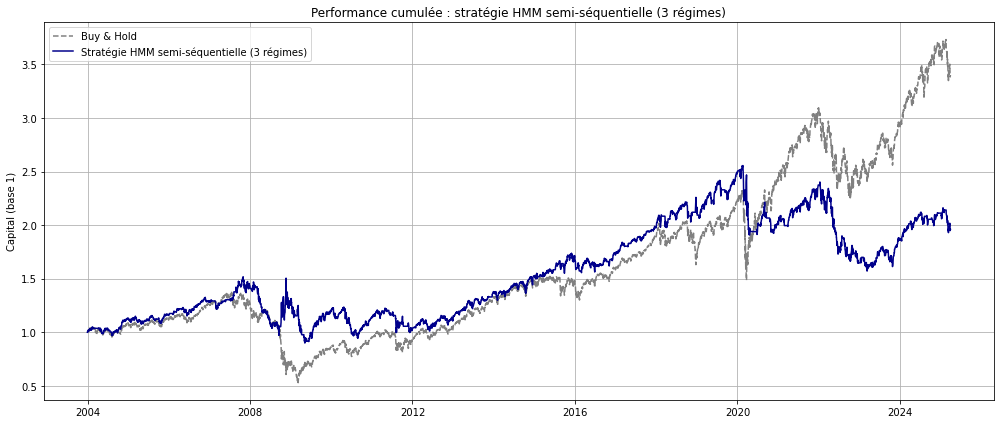


📊 Performance HMM semi-séquentielle (3 régimes) :
Rendement annualisé = 4.48%
Volatilité annualisée = 16.11%
Sharpe ratio = 0.28


In [14]:
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm

# Paramètres
rolling_window = 1000
refit_every = 10
positions = []
dates = []
returns_strategy = []

model_roll = None
viterbi_states = None
last_transmat = None
last_state = None
remap = None

# 📊 Boucle principale
loop_range = range(rolling_window, len(data) - 1)
for t in tqdm(loop_range, desc="⏳ HMM semi-séquentiel à 3 régimes"):
    window_returns = returns[t - rolling_window:t]

    if (t - rolling_window) % refit_every == 0:
        try:
            if np.var(window_returns) < 1e-7:
                continue

            model_roll = GaussianHMM(n_components=3, covariance_type='full', n_iter=100)
            model_roll.fit(window_returns)
            viterbi_states = model_roll.predict(window_returns)

            vols = [np.var(window_returns[viterbi_states == i]) for i in range(3)]
            order = np.argsort(vols)
            remap = {old: new for new, old in enumerate(order)}
            viterbi_states = np.vectorize(remap.get)(viterbi_states)

            last_state = viterbi_states[-1]
            last_transmat = model_roll.transmat_[order][:, order]

        except:
            continue

    if model_roll is None or last_transmat is None:
        continue

    # 🔮 Prédiction du régime de demain
    proba_next = last_transmat[last_state]
    pred_next_state = np.argmax(proba_next)
    last_state = pred_next_state

    # ✅ Stratégie : long = 0, cash = 1, short = 2
    pos = {0: 1, 1: 0, 2: -1}[pred_next_state]
    r_tomorrow = data['Log_Returns'].iloc[t + 1]

    positions.append(pos)
    dates.append(data.index[t + 1])
    returns_strategy.append(pos * r_tomorrow)

# 📊 Résultats
df_seq3 = pd.DataFrame({
    'Date': dates,
    'Position': positions,
    'Return_Strategy': returns_strategy
}).set_index('Date')

df_seq3['Cumulative_Strategy'] = (1 + df_seq3['Return_Strategy']).cumprod()
df_seq3['Cumulative_Market'] = (1 + data['Log_Returns'].loc[df_seq3.index]).cumprod()

# 📈 Courbe de performance
plt.figure(figsize=(14, 6))
plt.plot(df_seq3.index, df_seq3['Cumulative_Market'], label='Buy & Hold', linestyle='--', color='gray')
plt.plot(df_seq3.index, df_seq3['Cumulative_Strategy'], label='Stratégie HMM semi-séquentielle (3 régimes)', color='darkblue')
plt.title("Performance cumulée : stratégie HMM semi-séquentielle (3 régimes)")
plt.ylabel("Capital (base 1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Statistiques
mean_seq3 = df_seq3['Return_Strategy'].mean() * 252
vol_seq3 = df_seq3['Return_Strategy'].std() * np.sqrt(252)
sharpe_seq3 = mean_seq3 / vol_seq3

print("\n📊 Performance HMM semi-séquentielle (3 régimes) :")
print(f"Rendement annualisé = {mean_seq3:.2%}")
print(f"Volatilité annualisée = {vol_seq3:.2%}")
print(f"Sharpe ratio = {sharpe_seq3:.2f}")


# HMM basic Static 

[*********************100%***********************]  1 of 1 completed
🚨 HMM 4 régimes + Real Panic Mode:   0%|                                                                                                                                          | 0/5847 [00:00<?, ?it/s]Model is not converging.  Current: 1442.9777168634816 is not greater than 1443.3002048498747. Delta is -0.32248798639307097
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.

Model is not converging.  Current: 1475.6009305021278 is not greater than 1475.652789965175. Delta is -0.0518594630473217
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1477.408116991528 is not greater than 1477.7748430906256. Delta is -0.3667260990976047
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 

Model is not converging.  Current: 1466.1230698782654 is not greater than 1466.5632221452338. Delta is -0.44015226696842547
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib

🚨 HMM 4 régimes + Real Panic Mode:   4%|████▉                                                                                                                          | 226/5847 [00:02<00:52, 106.17it/s]Model is not converging.  Current: 1374.0489815422616 is not greater than 1374.1565226595508. Delta is -0.10754111728920179
Model is not converging.  Current: 1387.636268325486 is not greater than 1387.6417955215743. Delta is -0.005527196088223718
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid

🚨 HMM 4 régimes + Real Panic Mode:   5%|██████▍                                                                                                                         | 293/5847 [00:02<01:00, 91.58it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1395.5237570538884 is not greater than 1395.5616078653682. Delta is -0.037850811479756885
🚨 HMM 4 régimes + Real Panic Mode:   7%|████████▎                                                                                                                       | 381/5847 [00:03<01:01, 89.55it/s]Model is not converging.  Current: 1404.8468568801786 is not greater than 1404.9222604543934. Delta is -0.07540357421476074
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no tra

🚨 HMM 4 régimes + Real Panic Mode:   8%|██████████▏                                                                                                                     | 466/5847 [00:04<01:07, 79.60it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

🚨 HMM 4 régimes + Real Panic Mode:   9%|███████████▊                                                                                                                   | 546/5847 [00:05<00:51, 103.90it/s]Model is not converging.  Current: 1468.5933921977157 is not greater than 1468.6082169807187. Delta is -0.014824783002950426
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packa

🚨 HMM 4 régimes + Real Panic Mode:  11%|█████████████▉                                                                                                                  | 638/5847 [00:06<00:54, 96.19it/s]Model is not converging.  Current: 1499.318199376594 is not greater than 1499.3369320054114. Delta is -0.01873262881736082
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1537.76113651405

🚨 HMM 4 régimes + Real Panic Mode:  12%|███████████████▎                                                                                                               | 703/5847 [00:07<00:45, 113.95it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Model is not converging.  Current: 1604.9332500135104 is not greater than 1604.953936236221. Delta is -0.02068622271053755
Model is not converging.  Current: 1605.2207269945457 is not greater than 1605.3968189739064. Delta is -0.1760919793607627
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered i

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
🚨 HMM 4 régimes + Real Panic Mode:  13%|████████████████▋                                                                                                              | 766/5847 [00:07<00:42, 120.05it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1618.028310577241 is not greater than 1618.1412991435811. Delta is -0.11298856634016374
Model is not converging.  Current: 1668.794207568593 is not greater than 1668.976879

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode:  14%|██████████████████▏                                                                                                            | 836/5847 [00:08<00:42, 118.88it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axi

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode:  16%|███████████████████▊                                                                                                           | 911/5847 [00:08<00:35, 139.62it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axi

🚨 HMM 4 régimes + Real Panic Mode:  17%|█████████████████████▎                                                                                                         | 981/5847 [00:09<00:33, 144.04it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some 

🚨 HMM 4 régimes + Real Panic Mode:  18%|██████████████████████▊                                                                                                       | 1056/5847 [00:09<00:34, 139.03it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/nump

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * m

🚨 HMM 4 régimes + Real Panic Mode:  21%|█████████████████████████▉                                                                                                    | 1204/5847 [00:10<00:32, 143.77it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/nump

🚨 HMM 4 régimes + Real Panic Mode:  22%|███████████████████████████▍                                                                                                  | 1276/5847 [00:11<00:34, 132.87it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/nump

🚨 HMM 4 régimes + Real Panic Mode:  23%|████████████████████████████▊                                                                                                 | 1336/5847 [00:12<00:36, 124.38it/s]Model is not converging.  Current: 1775.6833017119045 is not greater than 1775.9281239220365. Delta is -0.24482221013204253
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/s

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode:  24%|██████████████████████████████                                                                                                | 1396/5847 [00:12<00:33, 133.53it/s]Model is not converging.  Current: 1781.9220023944417 is not greater than 1782.6103278099624. Delta is -0.6883254155206942
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/si

🚨 HMM 4 régimes + Real Panic Mode:  25%|███████████████████████████████▍                                                                                              | 1456/5847 [00:12<00:33, 132.39it/s]Model is not converging.  Current: 1728.7272751012101 is not greater than 1730.6462681556739. Delta is -1.9189930544637264
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/si

🚨 HMM 4 régimes + Real Panic Mode:  26%|████████████████████████████████▊                                                                                             | 1521/5847 [00:13<00:31, 137.04it/s]Model is not converging.  Current: 1676.5051619127325 is not greater than 1678.7435708629246. Delta is -2.2384089501920243
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/si

🚨 HMM 4 régimes + Real Panic Mode:  27%|██████████████████████████████████▍                                                                                           | 1596/5847 [00:13<00:32, 132.56it/s]Model is not converging.  Current: 1593.0202848891445 is not greater than 1594.5863119857272. Delta is -1.5660270965827294
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1595.00746676275

Model is not converging.  Current: 1578.591686404207 is not greater than 1578.6172152585598. Delta is -0.025528854352842245
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode:  28%|███████████████████████████████████▊                                                                                          | 1659/5847 [00:14<00:35, 119.13it/s]Model is not converging.  Current: 1565.0811701834

🛑 Panic mode ACTIVÉ le 2008-10-10 00:00:00


🚨 HMM 4 régimes + Real Panic Mode:  30%|█████████████████████████████████████▌                                                                                         | 1727/5847 [00:15<00:43, 95.62it/s]Model is not converging.  Current: 1457.615289416039 is not greater than 1457.6587443921355. Delta is -0.043454976096427345
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/s

✅ Panic mode DÉSACTIVÉ le 2008-11-26 00:00:00


Model is not converging.  Current: 1416.4186092986847 is not greater than 1416.4268034567042. Delta is -0.008194158019477982
🚨 HMM 4 régimes + Real Panic Mode:  30%|██████████████████████████████████████▏                                                                                        | 1757/5847 [00:15<00:46, 88.11it/s]Model is not converging.  Current: 1413.1202625581122 is not greater than 1413.134873074203. Delta is -0.01461051609066999
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid

🚨 HMM 4 régimes + Real Panic Mode:  32%|████████████████████████████████████████▋                                                                                      | 1871/5847 [00:17<00:53, 73.75it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
🚨 HMM 4 régimes + Real Panic Mode:  32%|████████████████████████████████████████▊                                                                                      | 1881/5847 [00:17<00:54, 72.59it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(ar

🚨 HMM 4 régimes + Real Panic Mode:  34%|███████████████████████████████████████████▏                                                                                   | 1991/5847 [00:18<01:04, 59.72it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Model is not converging.  Current: 1289.206075233807 is not greater than 1289.4634255084686. Delta is -0.2573502746615759
Model is not converging.  Current: 1298.0866741624402 is not greater than 1298.0867978281906. Delta is -0.00012366575037958683
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountere

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
🚨 HMM 4 régimes + Real Panic Mode:  36%|██████████████████████████████████████████

🚨 HMM 4 régimes + Real Panic Mode:  38%|███████████████████████████████████████████████▉                                                                               | 2206/5847 [00:21<00:42, 85.47it/s]Model is not converging.  Current: 1367.6497266626 is not greater than 1367.6708730045887. Delta is -0.021146341988696804
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
🚨 HMM 4 régimes + Real Panic Mode:  38%|████████████████████████████████████████████████▏                                                                              | 2216/5847 [00:21<00:41, 86.91it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=a

🚨 HMM 4 régimes + Real Panic Mode:  39%|██████████████████████████████████████████████████                                                                             | 2306/5847 [00:23<00:42, 82.86it/s]Model is not converging.  Current: 1491.9384022664717 is not greater than 1491.950594567239. Delta is -0.012192300767310371
Model is not converging.  Current: 1505.939456641264 is not greater than 1506.192459862029. Delta is -0.25300322076486736
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid v

Model is not converging.  Current: 1571.73864507219 is not greater than 1573.7156047813337. Delta is -1.9769597091437845
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode:  41%|███████████████████████████████████████████████████▏                                                                          | 2376/5847 [00:23<00:28, 120.90it/s]Model is not converging.  Current: 1570.878125134343 

Model is not converging.  Current: 1544.9961089219007 is not greater than 1545.5426496589084. Delta is -0.5465407370077173
🚨 HMM 4 régimes + Real Panic Mode:  42%|████████████████████████████████████████████████████▍                                                                         | 2436/5847 [00:24<00:28, 119.13it/s]Model is not converging.  Current: 1538.4403127530063 is not greater than 1538.5925260684842. Delta is -0.15221331547786576
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
🚨 HMM 4 régimes + Real Panic Mode:  43%|██████████████████████████████████████████████████████▏                                                                       | 2516/5847 [00:24<00:32, 101.22it/s]Model is not converging.  Current: 1485.870401827148 is not greater than 1485.9690498909072. Delta is -0.09864806375912849
Model is not converging.  Current: 1483.3406446220688 is not greater than 1483.5507047501849. Delta is -0.21006012811608343
🚨 HMM 4 régimes + Real Panic Mode:  43%|██████████████████████████████████████████████████████▍                                                                       | 2527/5847 [00:24<00:32, 103.07it/s]Model is not converging.  Current: 1481.373447349755

🚨 HMM 4 régimes + Real Panic Mode:  45%|█████████████████████████████████████████████████████████                                                                      | 2626/5847 [00:26<00:35, 91.37it/s]Model is not converging.  Current: 1525.387096315193 is not greater than 1525.5111680155007. Delta is -0.12407170030769521
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode:  45%|███████████

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
🚨 HMM 4 régimes + Real Panic Mode:  47%|███████████████████████████████████████████████████████████▎                                                                  | 2753/5847 [00:27<00:28, 110.04it/s]Model is not converging.  Current: 1551.7580351666206 is not greater than 1552.0742521452473. Delta is -0.3162169786266986
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeri

Model is not converging.  Current: 1553.4280751123981 is not greater than 1553.4606623651187. Delta is -0.03258725272053198
🚨 HMM 4 régimes + Real Panic Mode:  49%|█████████████████████████████████████████████████████████████▉                                                                | 2876/5847 [00:28<00:23, 126.99it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1588.2104867384

Model is not converging.  Current: 1633.7165234865631 is not greater than 1633.7524663402528. Delta is -0.03594285368967576
Model is not converging.  Current: 1638.6910319981907 is not greater than 1638.824299778167. Delta is -0.1332677799762223
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode:  51%|███████████████████████████████████████████████████████████████▋                           

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
🚨 HMM 4 régimes + Real Panic Mode:  52%|█████████████████████████████████████████████████████████████████▏                                                            | 3026/5847 [00:29<00:27, 104.39it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
🚨 HMM 4 régimes + Real Panic Mode:  52%|█████████████████████████████████████████████████████████████████▉                                        

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
🚨 HMM 4 régimes + Real Panic Mode:  53%|██████████████████████████████████████████████████████████████████▊                                                           | 3101/5847 [00:30<00:24, 110.07it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/nump

Model is not converging.  Current: 1758.6118850669202 is not greater than 1758.850925050844. Delta is -0.2390399839237034
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no trans

🚨 HMM 4 régimes + Real Panic Mode:  56%|██████████████████████████████████████████████████████████████████████                                                        | 3251/5847 [00:31<00:20, 125.80it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/nump

🚨 HMM 4 régimes + Real Panic Mode:  57%|███████████████████████████████████████████████████████████████████████▋                                                      | 3326/5847 [00:32<00:21, 115.96it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

🚨 HMM 4 régimes + Real Panic Mode:  58%|█████████████████████████████████████████████████████████████████████████▎                                                    | 3401/5847 [00:32<00:19, 123.24it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axi

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode:  60%|███████████████████████████████████████████████████████████████████████████▌                                                   | 3481/5847 [00:33<00:26, 89.90it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
🚨 HMM 4 régimes + Real Panic Mode:  61%|██████████████████████████████████████████

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
🚨 HMM 4 régimes + Real Panic Mode:  62%|██████████████████████████████████████████████████████████████████████████████▎                                               | 3636/5847 [00:35<00:20, 108.24it/s]Model is not converging.  Current: 1617.2489040576863 is not greater than 1617.2956931076528. Delta is -0.0467890499664918
Model is not converging.  Current: 1634.1722161318485 is not greater than 1634.7973263522745. Delta is -0.6251102204259951
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/from

🚨 HMM 4 régimes + Real Panic Mode:  63%|███████████████████████████████████████████████████████████████████████████████▊                                              | 3706/5847 [00:35<00:16, 131.76it/s]Model is not converging.  Current: 1619.6573106709152 is not greater than 1619.6756419889498. Delta is -0.018331318034597643
Model is not converging.  Current: 1639.7976978195054 is not greater than 1640.219307241505. Delta is -0.42160942199961937
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid

Model is not converging.  Current: 1655.5614323424522 is not greater than 1655.5623078369724. Delta is -0.0008754945201872033
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1657.9909753055053 is not greater than 1658.0498951160384. Delta is -0.058919810533097916
🚨 HMM 4 régimes + Real Panic Mode:  65%|█████████████████████████████████████████████████████████████████████████████████▍    

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                          | 3876/5847 [00:36<00:14, 133.24it/s]Model is not converging.  Current: 1665.0945911735373 is not greater than 1665.1890258817793. Delta is -0.0944347082420336
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/si

🚨 HMM 4 régimes + Real Panic Mode:  68%|█████████████████████████████████████████████████████████████████████████████████████▏                                        | 3956/5847 [00:37<00:13, 139.59it/s]Model is not converging.  Current: 1750.4242161662096 is not greater than 1750.952811507605. Delta is -0.5285953413954303
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1752.712093181842

Model is not converging.  Current: 1787.2378905573582 is not greater than 1788.0472550178367. Delta is -0.8093644604784913
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1758.1344413869435 is not greater than 1758.6589246134558. Delta is -0.5244832265123023
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <

🚨 HMM 4 régimes + Real Panic Mode:  70%|███████████████████████████████████████████████████████████████████████████████████████▊                                      | 4073/5847 [00:38<00:11, 150.22it/s]Model is not converging.  Current: 1847.5089517911517 is not greater than 1848.836112375013. Delta is -1.327160583861314
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1752.5425064509473

🚨 HMM 4 régimes + Real Panic Mode:  71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4156/5847 [00:38<00:12, 131.98it/s]Model is not converging.  Current: 1829.8858715654783 is not greater than 1829.896394941107. Delta is -0.010523375628736176
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/s

🚨 HMM 4 régimes + Real Panic Mode:  73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4251/5847 [00:39<00:11, 136.00it/s]Model is not converging.  Current: 1785.7372266515695 is not greater than 1786.9206289408858. Delta is -1.183402289316291
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1732.050427054296

Model is not converging.  Current: 1671.1707120931642 is not greater than 1671.4710385331753. Delta is -0.30032644001107656
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode:  75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4361/5847 [00:40<00:11, 127.43it/s]Model is not converging.  Current: 1638.7733137890

Model is not converging.  Current: 1664.3597942722297 is not greater than 1664.6016736315514. Delta is -0.24187935932172877
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1668.5093092085012 is not greater than 1669.1006184086739. Delta is -0.5913092001726454
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom 

Model is not converging.  Current: 1662.570255738233 is not greater than 1663.1371479239156. Delta is -0.5668921856824909
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1634.7147443505953 is not greater than 1635.1507665581125. Delta is -0.436022207517226
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 

🛑 Panic mode ACTIVÉ le 2020-03-16 00:00:00


🚨 HMM 4 régimes + Real Panic Mode:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4604/5847 [00:42<00:10, 122.19it/s]Model is not converging.  Current: 1612.9790459297617 is not greater than 1613.0975230307877. Delta is -0.11847710102597375
Model is not converging.  Current: 1599.0671491217722 is not greater than 1599.1462529773326. Delta is -0.07910385556033361
🚨 HMM 4 régimes + Real Panic Mode:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4617/5847 [00:42<00:11, 104.74it/s]Model is not converging.  Current: 1540.1730095817293 is not greater than 1540.2929969626296. Delta is -0.11998738090028382
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
🚨 HMM 4 régimes + Real Panic Mode:  79%|████

✅ Panic mode DÉSACTIVÉ le 2020-04-29 00:00:00


Model is not converging.  Current: 1555.2711840334866 is not greater than 1555.4565078682815. Delta is -0.1853238347948718
🚨 HMM 4 régimes + Real Panic Mode:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4652/5847 [00:42<00:12, 96.23it/s]Model is not converging.  Current: 1547.363833435419 is not greater than 1547.5964909250656. Delta is -0.23265748964649902
Model is not converging.  Current: 1517.8100139205676 is not greater than 1517.9980673338225. Delta is -0.1880534132549201
Model is not converging.  Current: 1541.0351152094806 is not greater than 1541.053731636447. Delta is -0.018616426966445943
🚨 HMM 4 régimes + Real Panic Mode:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4666/5847 [00:42<00:12, 93.32it/s]Model is not converging.  Current: 1542.176731406102 is not greater than 1542.20794944578. Delta is -

🚨 HMM 4 régimes + Real Panic Mode:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 4811/5847 [00:44<00:10, 96.24it/s]Model is not converging.  Current: 1551.0554393151738 is not greater than 1551.4002407347082. Delta is -0.3448014195344058
Model is not converging.  Current: 1544.0487686068957 is not greater than 1544.0698626191518. Delta is -0.021094012256071437
🚨 HMM 4 régimes + Real Panic Mode:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4821/5847 [00:44<00:11, 90.70it/s]Model is not converging.  Current: 1544.1526895148106 is not greater than 1544.2393644888834. Delta is -0.08667497407282099
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/

Model is not converging.  Current: 1528.4058017135178 is not greater than 1528.5220087511348. Delta is -0.1162070376169595
🚨 HMM 4 régimes + Real Panic Mode:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4946/5847 [00:45<00:08, 106.53it/s]Model is not converging.  Current: 1552.2621967180198 is not greater than 1552.7777416166211. Delta is -0.5155448986013198
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid v

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1531.1200379583227 is not greater than 1531.2244470103396. Delta is -0.10440905201699024
Model is not converging.  Current: 1523.4027200368573 is not greater than 1524.1404872203937. Delta is -0.7377671835363344
🚨 HMM 4 régimes + Real Panic Mode:  86%|██████████████████████████████████████████████████████████████████████████████████████████

🚨 HMM 4 régimes + Real Panic Mode:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 5136/5847 [00:47<00:07, 94.74it/s]Model is not converging.  Current: 1557.5225951609539 is not greater than 1558.7732505341842. Delta is -1.2506553732303018
Model is not converging.  Current: 1553.4598820150145 is not greater than 1554.134568385966. Delta is -0.6746863709515765
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid va

Model is not converging.  Current: 1520.0092168530932 is not greater than 1520.0724645879175. Delta is -0.06324773482424462
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
🚨 HMM 4 régimes + Real Panic Mode:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 5281/5847 [00:48<00:06, 92.92it/s]Model is not converging.  Current: 1499.0866029848405 is not greater than 1499.9903120800557. Delta is -0.903709095215163
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.tr

🚨 HMM 4 régimes + Real Panic Mode:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 5331/5847 [00:49<00:04, 117.86it/s]Model is not converging.  Current: 1505.458123775918 is not greater than 1505.781147071699. Delta is -0.3230232957810131
Model is not converging.  Current: 1490.6497611841191 is not greater than 1491.3168488933786. Delta is -0.6670877092594765
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid val

Model is not converging.  Current: 1484.2015533526394 is not greater than 1485.1445410225729. Delta is -0.9429876699334727
🚨 HMM 4 régimes + Real Panic Mode:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5401/5847 [00:49<00:02, 149.17it/s]Model is not converging.  Current: 1483.3631503817526 is not greater than 1483.3734171506972. Delta is -0.010266768944575233
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid

Model is not converging.  Current: 1482.062097236833 is not greater than 1482.083413159961. Delta is -0.021315923127986025
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5467/5847 [00:50<00:02, 141.97it/s]Model is not converging.  Current: 1488.91402336193

🚨 HMM 4 régimes + Real Panic Mode:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5526/5847 [00:50<00:02, 133.83it/s]Model is not converging.  Current: 1489.2826987939877 is not greater than 1489.2961360159927. Delta is -0.01343722200499542
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1485.6597848221

Model is not converging.  Current: 1530.7971896273643 is not greater than 1531.0724571924147. Delta is -0.27526756505039884
Model is not converging.  Current: 1531.4727177257557 is not greater than 1531.8161128094619. Delta is -0.3433950837061275
🚨 HMM 4 régimes + Real Panic Mode:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5601/5847 [00:51<00:01, 149.03it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no trans

Model is not converging.  Current: 1578.4030137466284 is not greater than 1578.558739348875. Delta is -0.15572560224654808
Model is not converging.  Current: 1602.5000228394972 is not greater than 1603.101226815127. Delta is -0.6012039756296872
🚨 HMM 4 régimes + Real Panic Mode:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5691/5847 [00:51<00:00, 159.59it/s]Model is not converging.  Current: 1592.3128943681897 is not greater than 1592.9054635443783. Delta is -0.5925691761885901
Model is not converging.  Current: 1583.697423134815 is not greater than 1583.8154736017916. Delta is -0.11805046697668331
Model is not converging.  Current: 1610.629119347124 is not greater than 1611.8655954435903. Delta is -1.2364760964662764
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dt

🚨 HMM 4 régimes + Real Panic Mode:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5762/5847 [00:52<00:00, 144.74it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/nump

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
🚨 HMM 4 régimes + Real Panic Mode: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5847/5847 [00:52<00:00, 110.66it/s]


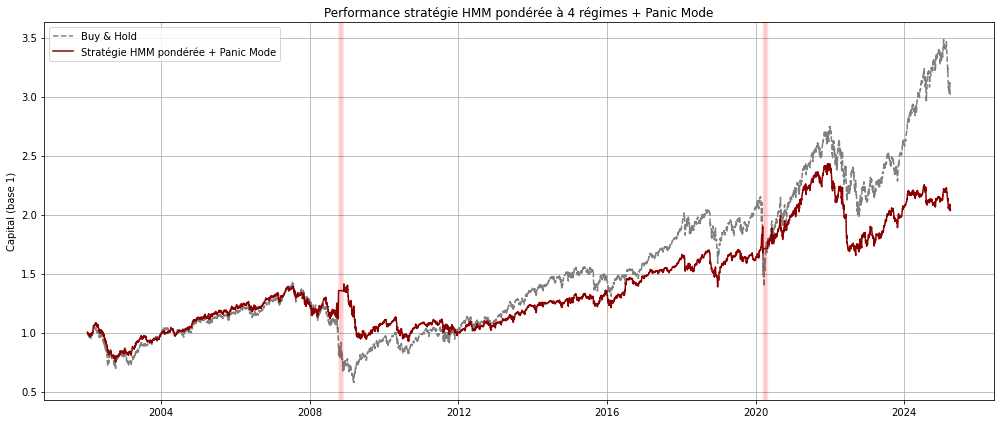


📊 Résultats finaux :
Rendement annualisé : 4.20%
Volatilité annualisée : 13.84%


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm
import yfinance as yf

# 📥 Données
data = yf.download('^GSPC', start='2000-01-01', end='2025-04-01')
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)
returns = data['Log_Returns'].values.reshape(-1, 1)

# ⚙️ Paramètres
rolling_window = 500
refit_every = 5
positions = []
dates = []
returns_strategy = []
panic_flags = []

model_roll = None
viterbi_states = None
last_transmat = None
last_state = None
remap = None

# 🔐 Panic mode
panic_mode = False
panic_timer = 0

loop_range = range(rolling_window, len(data) - 1)
for t in tqdm(loop_range, desc="🚨 HMM 4 régimes + Real Panic Mode"):

    window_returns = returns[t - rolling_window:t]

    if (t - rolling_window) % refit_every == 0:
        try:
            model_roll = GaussianHMM(n_components=4, covariance_type='full', n_iter=1000)
            model_roll.fit(window_returns)
            viterbi_states = model_roll.predict(window_returns)

            vols = [np.var(window_returns[viterbi_states == i]) for i in range(4)]
            order = np.argsort(vols)
            remap = {old: new for new, old in enumerate(order)}
            viterbi_states = np.vectorize(remap.get)(viterbi_states)

            last_state = viterbi_states[-1]
            last_transmat = model_roll.transmat_[order][:, order]

        except:
            continue

    if model_roll is None or last_transmat is None:
        continue

    # 📉 Stats marché récents
    rolling_vol = np.std(returns[t-20:t]) * np.sqrt(252)
    recent_return = np.mean(returns[t-5:t])

    # 🔥 1. Panic Mode déclenchement
    if not panic_mode and rolling_vol > 0.6 and recent_return < -0.01:
        panic_mode = True
        panic_timer = 30
        print(f"🛑 Panic mode ACTIVÉ le {data.index[t]}")

    # 🔓 2. Panic Mode désactivation
    elif panic_mode:
        if (rolling_vol < 0.3 and recent_return > 0) or panic_timer <= 0:
            panic_mode = False
            print(f"✅ Panic mode DÉSACTIVÉ le {data.index[t]}")
        else:
            panic_timer -= 1

    # 📈 3. Allocation
    if panic_mode:
        pos = 0  # 🛑 LOCK
        panic_flags.append(1)
    else:
        proba_next = last_transmat[last_state]
        pos = proba_next[0]*1 + proba_next[1]*0.5 + proba_next[2]*(-0.5) + proba_next[3]*(-1)
        last_state = np.argmax(proba_next)
        panic_flags.append(0)

    r_tomorrow = data['Log_Returns'].iloc[t + 1]
    positions.append(pos)
    dates.append(data.index[t + 1])
    returns_strategy.append(pos * r_tomorrow)

# 📊 Résultats
df_panic = pd.DataFrame({
    'Date': dates,
    'Position': positions,
    'Return_Strategy': returns_strategy,
    'Panic_Mode': panic_flags
}).set_index('Date')

df_panic['Cumulative_Strategy'] = (1 + df_panic['Return_Strategy']).cumprod()
df_panic['Cumulative_Market'] = (1 + data['Log_Returns'].loc[df_panic.index]).cumprod()

# 📈 Graphe perf + panic zones
plt.figure(figsize=(14, 6))
plt.plot(df_panic.index, df_panic['Cumulative_Market'], label='Buy & Hold', linestyle='--', color='gray')
plt.plot(df_panic.index, df_panic['Cumulative_Strategy'], label='Stratégie HMM pondérée + Panic Mode', color='darkred')

# Barres rouges pour panic
for i in range(len(df_panic)):
    if df_panic['Panic_Mode'].iloc[i] == 1:
        plt.axvline(df_panic.index[i], color='red', alpha=0.02)

plt.title("Performance stratégie HMM pondérée à 4 régimes + Panic Mode")
plt.ylabel("Capital (base 1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Statistiques
mean = df_panic['Return_Strategy'].mean() * 252
vol = df_panic['Return_Strategy'].std() * np.sqrt(252)

print("\n📊 Résultats finaux :")
print(f"Rendement annualisé : {mean:.2%}")
print(f"Volatilité annualisée : {vol:.2%}")



[*********************100%***********************]  1 of 1 completed
Model is not converging.  Current: 20518.16033456869 is not greater than 20518.193354419054. Delta is -0.03301985036523547
Model is not converging.  Current: 20258.857946280088 is not greater than 20258.871339733112. Delta is -0.013393453024036717


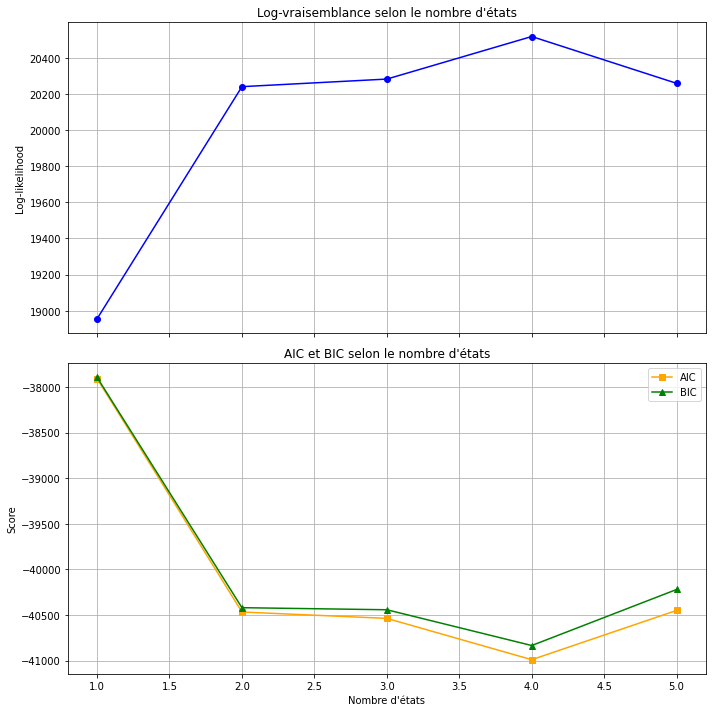


✅ Nombre optimal d'états selon le BIC : 4


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import yfinance as yf

# 📥 Données
data = yf.download('^GSPC', start='2000-01-01', end='2025-04-01')
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)
returns = data['Log_Returns'].values.reshape(-1, 1)

# 🔁 Comparaison pour différents nombres d'états
log_likelihoods = []
aics = []
bics = []
K_range = range(1, 6)
n_obs = len(returns)

for k in K_range:
    try:
        model = GaussianHMM(n_components=k, covariance_type='full', n_iter=1000, random_state=42)
        model.fit(returns)
        log_likelihood = model.score(returns)

        # ⚙️ Nombre de paramètres :
        # (k-1) pour startprob, k(k-1) pour transmat, k pour variances, k pour moyennes
        n_params = (k - 1) + (k * (k - 1)) + k + k

        aic = -2 * log_likelihood + 2 * n_params
        bic = -2 * log_likelihood + n_params * np.log(n_obs)

        log_likelihoods.append(log_likelihood)
        aics.append(aic)
        bics.append(bic)

    except Exception as e:
        print(f"Erreur pour {k} états : {e}")
        log_likelihoods.append(np.nan)
        aics.append(np.nan)
        bics.append(np.nan)

# 📈 Graphe comparatif
# 📊 Replot en 2 graphes pour meilleure lisibilité
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Graph 1 : log-vraisemblance
ax[0].plot(K_range, log_likelihoods, marker='o', color='blue')
ax[0].set_title("Log-vraisemblance selon le nombre d'états")
ax[0].set_ylabel("Log-likelihood")
ax[0].grid(True)

# Graph 2 : AIC / BIC
ax[1].plot(K_range, aics, marker='s', label='AIC', color='orange')
ax[1].plot(K_range, bics, marker='^', label='BIC', color='green')
ax[1].set_title("AIC et BIC selon le nombre d'états")
ax[1].set_xlabel("Nombre d'états")
ax[1].set_ylabel("Score")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# ✅ Meilleur modèle selon BIC
best_k = K_range[np.nanargmin(bics)]
print(f"\n✅ Nombre optimal d'états selon le BIC : {best_k}")


🔍 Optimisation de la fenêtre:   0%|                      | 0/5 [00:00<?, ?it/s]Model is not converging.  Current: 709.2492717088172 is not greater than 709.3104839499724. Delta is -0.06121224115520363
Model is not converging.  Current: 715.0031243892861 is not greater than 715.1053951762071. Delta is -0.10227078692105351
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 710.2997775650008 is not greater than 710.3

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 735.3381353536743 is not greater than 735.3398247493448. Delta is -0.0016893956704961965
Model is not converging.  Current: 750.9911316109875 is not greater than 751.0380607014357. Delta is -0.04692909044820226
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/sit

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, ou

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, ou

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, ou

Model is not converging.  Current: 821.7826814869892 is not greater than 821.9745156999394. Delta is -0.19183421295019798
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 772.0234447816251 is not greater than 772.0673892059737. Delta is -0.04394442434852408
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _me

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 676.6348035844259 is not greater than 676.7007753813674. Delta is -0.06597179694153965
Model is not converging.  Current: 704.2539275065341 is not greater than 704.3085145642192. Delta is -0.05458705768512573
Model is not converging.  Current: 741.825487236502 is not greater than 741.8436017273966. Delta is -0.01811449089461803
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encounter

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, ou

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, ou

Model is not converging.  Current: 891.9463872364031 is not greater than 891.950922188763. Delta is -0.0045349523599043096
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 896.5785209233782 is not greater than 897.0093679266402. Delta is -0.430847003261988
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _met

Model is not converging.  Current: 829.8005853456876 is not greater than 830.2722795540377. Delta is -0.4716942083500726
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 829.389853202724 is not greater than 829.5310385802095. Delta is -0.14118537748549898
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _meth

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 784.7438795051225 is not greater than 785.2084557383408. Delta is -0.46457623321828123
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/n

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 802.9144936520091 is not greater than 803.1329562728317. Delta is -0.21846262082260637
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/n

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/j

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: 

Model is not converging.  Current: 1467.158898669621 is not greater than 1467.2109353625024. Delta is -0.05203669288130186
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was eve

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1553.1191169448007 is not greater than 1553.3248092902095. Delta is -0.20569234540880643
Model is not converging.  Current: 1576.529407912627 is not greater than 1576.6471425112788. Delta is -0.11773459865185032
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1775.409523485829 is not greater than 1775.9276919427614. Delta is -0.5181684569324716
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/n

Model is not converging.  Current: 1598.635375082947 is not greater than 1599.0156113009612. Delta is -0.3802362180142609
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1599.1112792981849 is not greater than 1599.1322001887472. Delta is -0.020920890562365457
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return 

Model is not converging.  Current: 1320.9039346008233 is not greater than 1320.9778005241371. Delta is -0.07386592331386055
Model is not converging.  Current: 1421.0717601037786 is not greater than 1421.268453457956. Delta is -0.19669335417734146
Model is not converging.  Current: 1487.8381434093437 is not greater than 1488.247904904538. Delta is -0.4097614951942887
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /
Model is not converging.  Current: 1565.1519290132371 is not greater than 1565.3709659864633. Delta is -0.2190369732261388
Model is not converging.  Current: 1576.98621

Model is not converging.  Current: 1650.4372435069008 is not greater than 1651.6474156659826. Delta is -1.2101721590818215
Model is not converging.  Current: 1674.5274551295975 is not greater than 1674.5677688233638. Delta is -0.040313693766393044
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmle

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, ou

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1672.4634638281382 is not greater than 1672.582694113296. Delta is -0.11923028515775513
Model is not converging.  Current: 1661.985816208896 is not greater than 1664.2732147118418. Delta is -2.2873985029457344
Model is not converging.  Current: 1685.3196137112768 is not greater than 1685.574783186842. Delta is -0.2551694755652534
/Users/jeremy.duriez/opt/anaconda3

Model is not converging.  Current: 1760.1353586258292 is not greater than 1760.1488113766818. Delta is -0.013452750852593454
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-package

Model is not converging.  Current: 1488.6830317886127 is not greater than 1488.7640581524367. Delta is -0.081026363824094
Model is not converging.  Current: 1493.9096774438835 is not greater than 1494.0921787047766. Delta is -0.1825012608931047
Model is not converging.  Current: 1492.1972641637574 is not greater than 1492.5522793604587. Delta is -0.355015196701288
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3

Model is not converging.  Current: 1630.5573304468417 is not greater than 1630.8506016113497. Delta is -0.2932711645080417
Model is not converging.  Current: 1657.3898728811732 is not greater than 1657.4132591678208. Delta is -0.023386286647564702
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 2338.4382536657668 is not greater than 2338.5718846203818. Delta is -0.13363095461500052
Model is not converging.  Current: 2333.1529092782994 is not greater than 2333.498999800078. Delta is -0.34609052177847843
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 2498.095930371034 is not greater than 2498.220116677315. Delta is -0.1241863

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, ou

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, ou

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 2644.9109288400186 is not greater than 2644.9790609835586. Delta is -0.06813214353996955
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWa

Model is not converging.  Current: 2383.353271927445 is not greater than 2383.451092559568. Delta is -0.09782063212333014
Model is not converging.  Current: 2345.707910711753 is not greater than 2345.8614327168157. Delta is -0.15352200506276859
Model is not converging.  Current: 2332.075355745136 is not greater than 2332.1746163062535. Delta is -0.09926056111726211
Model is not converging.  Current: 2314.7913022531898 is not greater than 2314.9324807983367. Delta is -0.14117854514688588
Model is not converging.  Current: 2266.0074972677335 is not greater than 2266.0611897861677. Delta is -0.05369251843421807
Model is not converging.  Current: 2254.707417917448 is not greater than 2254.8914674014127. Delta is -0.18404948396482723
Model is not converging.  Current: 2206.230590383275 is not greater than 2206.4943938139995. Delta is -0.2638034307246926
Model is not converging.  Current: 2192.786152427771 is not greater than 2192.8023389276423. Delta is -0.016186499871309934
Model is not co

Model is not converging.  Current: 3125.617853795322 is not greater than 3125.6546732712454. Delta is -0.03681947592349388
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 3176.5962051848737 is not greater than 3176.889029966503. Delta is -0.29282478162940606
Model is not converging.  Current: 3213.847010985469 is not greater than 3213.8482426562987. Delta is -0.0012316708298385493
/Users/jeremy.duriez/opt/anaco

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /
Model is not converging.  Current: 3543.3827832163693 is not greater than 3543.6969769026496. Delta is -0.314193686280305
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 3543.3649892946264 is not greater than 3543.581855434356. Delta is -0.2

Model is not converging.  Current: 2862.444516641004 is not greater than 2862.445697861072. Delta is -0.0011812200677923101
Model is not converging.  Current: 2869.18717882243 is not greater than 2869.352529737255. Delta is -0.1653509148250123
Model is not converging.  Current: 2853.0406300544155 is not greater than 2853.1664003591172. Delta is -0.12577030470174577
Model is not converging.  Current: 2859.548488512243 is not greater than 2859.569783912034. Delta is -0.0212953997911427
Model is not converging.  Current: 2850.8737667649557 is not greater than 2851.364339702239. Delta is -0.4905729372831047
Model is not converging.  Current: 2852.4737778196186 is not greater than 2852.7066639879376. Delta is -0.2328861683190553
Model is not converging.  Current: 2860.10037432905 is not greater than 2860.1830829752207. Delta is -0.08270864617088591
Model is not converging.  Current: 2840.5741019208795 is not greater than 2840.666404495105. Delta is -0.09230257422541399
Model is not convergi

Model is not converging.  Current: 3339.9537988693082 is not greater than 3340.0350992595695. Delta is -0.08130039026127633
Model is not converging.  Current: 3338.0008440725064 is not greater than 3338.1030106864027. Delta is -0.10216661389631554
Model is not converging.  Current: 3349.943440562065 is not greater than 3350.0401040935703. Delta is -0.09666353150532814
Model is not converging.  Current: 3355.795812842052 is not greater than 3355.968312829665. Delta is -0.17249998761326424
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 3371.495781110903 is not greater than 3371.5035521445093. Delta is -0.007771033606331912
Model is not converging.  Current: 3394.531869563068 is not greater than 3394.638534978953. D

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 3502.9437574107637 is not greater than 3502.9461527637345. Delta is -0.0023953529707796406
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packag

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 3174.639089546838 is not greater than 3174.7151503747564. Delta is -0.07606082791835433
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
🔍 Optimisation de la fenêtre:  80%|███████████▏  | 4/5 [04:05<01:05, 65.93s/it]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Us

Model is not converging.  Current: 4239.10008173196 is not greater than 4239.104802810604. Delta is -0.004721078644251975
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 4291.46328847931 is not greater than 4291.487569668656. Delta is -0.024281189345856546
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _me

Model is not converging.  Current: 3721.157360370578 is not greater than 3721.185184853043. Delta is -0.02782448246534841
Model is not converging.  Current: 3850.2933736711134 is not greater than 3850.3968601649917. Delta is -0.10348649387833575
Model is not converging.  Current: 3900.814592108461 is not greater than 3900.823730106064. Delta is -0.009137997602920223
Model is not converging.  Current: 3924.9404542498883 is not greater than 3925.2002993533224. Delta is -0.25984510343414513
Model is not converging.  Current: 3950.7220885096026 is not greater than 3950.7464829778864. Delta is -0.024394468283844617
Model is not converging.  Current: 3966.583545339078 is not greater than 3966.6266931036757. Delta is -0.04314776459796121
Model is not converging.  Current: 4017.1935028098137 is not greater than 4017.2134927019006. Delta is -0.019989892086869077
Model is not converging.  Current: 4002.1605724454666 is not greater than 4002.231126632586. Delta is -0.0705541871193418
Model is not

Model is not converging.  Current: 4412.383661672908 is not greater than 4412.399512648592. Delta is -0.01585097568386118
Model is not converging.  Current: 4386.308045737729 is not greater than 4386.5007917348885. Delta is -0.19274599715936347
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site

Model is not converging.  Current: 3870.5871176368446 is not greater than 3870.723803055761. Delta is -0.13668541891638597
Model is not converging.  Current: 3887.5233404522983 is not greater than 3887.539939006127. Delta is -0.0165985538287714
Model is not converging.  Current: 3880.534736869652 is not greater than 3880.8868211428844. Delta is -0.3520842732323217
Model is not converging.  Current: 3882.5571311480503 is not greater than 3882.693498193363. Delta is -0.13636704531290889
Model is not converging.  Current: 3882.480588383458 is not greater than 3882.4956101510784. Delta is -0.015021767620510218
Model is not converging.  Current: 3879.283906078458 is not greater than 3879.296500759889. Delta is -0.012594681430982746
🔍 Optimisation de la fenêtre: 100%|██████████████| 5/5 [05:35<00:00, 67.02s/it]


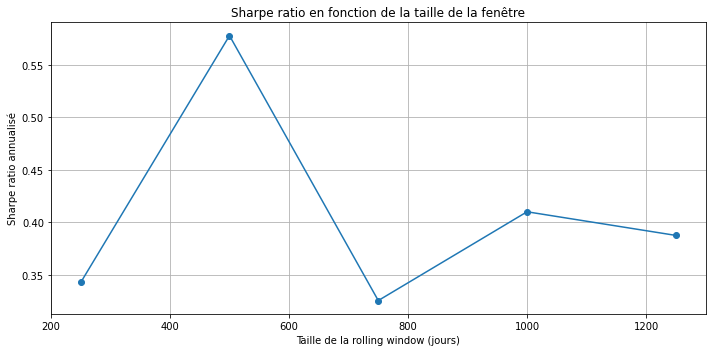

🏆 Meilleure taille de rolling window : 500 jours


In [39]:
# Paramètres à tester
window_sizes = [250, 500, 750, 1000, 1250]
sharpe_scores = []

for rw in tqdm(window_sizes, desc="🔍 Optimisation de la fenêtre"):

    model = None
    positions = []
    returns_strategy = []
    last_transmat = None
    last_state = None

    for t in range(rw, len(returns) - 1):
        window_returns = returns[t - rw:t]

        # Réestimation tous les 20 jours
        if (t - rw) % 20 == 0:
            try:
                model = GaussianHMM(n_components=3, covariance_type='full', n_iter=100)
                model.fit(window_returns)
                viterbi = model.predict(window_returns)
                vols = [np.var(window_returns[viterbi == i]) for i in range(3)]
                order = np.argsort(vols)
                last_transmat = model.transmat_[order][:, order]
                last_state = order.tolist().index(viterbi[-1])
            except:
                continue

        if model is None or last_transmat is None:
            continue

        # Prédiction du régime de demain
        p_next = last_transmat[last_state]
        pos = p_next[0]*1 + p_next[1]*0 + p_next[2]*(-1)
        last_state = np.argmax(p_next)

        r_tomorrow = data['Log_Returns'].iloc[t + 1]
        returns_strategy.append(pos * r_tomorrow)
        positions.append(pos)

    # Calcul du Sharpe
    strat = pd.Series(returns_strategy)
    sharpe = strat.mean() * 252 / (strat.std() * np.sqrt(252))
    sharpe_scores.append(sharpe)

# 🔍 Résultats
df_opt = pd.DataFrame({'Rolling_Window': window_sizes, 'Sharpe': sharpe_scores})

plt.figure(figsize=(10, 5))
plt.plot(df_opt['Rolling_Window'], df_opt['Sharpe'], marker='o')
plt.title("Sharpe ratio en fonction de la taille de la fenêtre")
plt.xlabel("Taille de la rolling window (jours)")
plt.ylabel("Sharpe ratio annualisé")
plt.grid(True)
plt.tight_layout()
plt.show()

best_rw = df_opt.loc[df_opt['Sharpe'].idxmax(), 'Rolling_Window']
print(f"🏆 Meilleure taille de rolling window : {int(best_rw)} jours")


# HMM test Static 

[*********************100%***********************]  1 of 1 completed
📊 HMM 4 régimes + Panic Mode:   0%|                                                                                                                                               | 0/5847 [00:00<?, ?it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1446.5072509638278 is not greater than 1446.764777477584. Delta is -0.2575265137561473
Model is not converging.  Current: 1446.1188205712363 is not greater than 1446.1293105021546. Delta is -0.010489930918311074
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtyp

Model is not converging.  Current: 1449.2051530350504 is not greater than 1449.3908431549874. Delta is -0.18569011993690765
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:   1%|▊                                                                                                                                     | 37/5847 [00:00<01:12, 80.62it/s]Model is not converging.  Current: 1441.5200333777

Model is not converging.  Current: 1475.6803526056374 is not greater than 1476.091289284425. Delta is -0.41093667878772067
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:   1%|█▉                                                                                                                                    | 82/5847 [00:00<01:06, 86.34it/s]Model is not converging.  Current: 1476.82944048581

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:   2%|██▋                                                                                                                                  | 118/5847 [00:01<01:14, 76.78it/s]Model is not converging.  Current: 1476.375715315282 is not greater than 1476.4069747668866. Delta is -0.03125945160468291
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeri

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1429.6207909089517 is not greater than 1430.1609093908314. Delta is -0.5401184818797446
📊 HMM 4 régimes + Panic Mode:   3%|███▌                                                                                                                                 | 157/5847 [00:01<01:14, 76.15it/s]Model is not converging.  Current: 1425.30424974641

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:   4%|████▊                                                                                                                                | 211/5847 [00:02<01:05, 86.06it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1393.7207747559523 is not greater than 1393.7292430134585. Delta is -0.008468257506137888
📊 HMM 4 régimes + Panic Mode:   5%|██████▏                                                                                                                              | 271/5847 [00:03<01:07, 82.41it/s]Model is not converging.  Current: 1406.4598490749167 is not greater than 1406.5564525328798. Delta is -0.09660345796305592
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib

📊 HMM 4 régimes + Panic Mode:   5%|███████▎                                                                                                                             | 319/5847 [00:03<01:12, 76.20it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/nump

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:   6%|████████▎                                                                                                                            | 368/5847 [00:04<01:26, 63.25it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some 

Model is not converging.  Current: 1402.5305007266281 is not greater than 1402.5552052880525. Delta is -0.02470456142441435
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:   7%|█████████▌                                                                                                                           | 421/5847 [00:05<01:23, 64.90it/s]Model is not converging.  Current: 1436.4755230537

📊 HMM 4 régimes + Panic Mode:   8%|██████████▋                                                                                                                          | 470/5847 [00:06<01:18, 68.34it/s]Model is not converging.  Current: 1428.15418412389 is not greater than 1428.185338739371. Delta is -0.031154615481000292
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/sit

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:   9%|███████████▊                                                                                                                         | 520/5847 [00:07<01:54, 46.53it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddo

📊 HMM 4 régimes + Panic Mode:  10%|████████████▊                                                                                                                        | 565/5847 [00:08<01:34, 56.04it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axi

📊 HMM 4 régimes + Panic Mode:  11%|█████████████▉                                                                                                                       | 614/5847 [00:08<01:19, 65.65it/s]Model is not converging.  Current: 1500.4197740147201 is not greater than 1500.4883924990236. Delta is -0.06861848430344253
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1457.7875815857237 is not greater than 1457.8169644170005. Delta is -0.029382831276734578
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  11%|███████████████▏                                                                                                                     | 667/5847 [00:09<01:10, 73.90it/s]Model is not converging.  Current: 1524.3276481592904 is not greater than 1524.3783617548597. Delta is -0.05071359556927746
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/s

📊 HMM 4 régimes + Panic Mode:  12%|████████████████▏                                                                                                                    | 712/5847 [00:10<01:09, 74.08it/s]Model is not converging.  Current: 1614.350291078181 is not greater than 1616.4233682674408. Delta is -2.0730771892597204
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/sit

📊 HMM 4 régimes + Panic Mode:  13%|█████████████████                                                                                                                    | 748/5847 [00:10<01:02, 80.96it/s]Model is not converging.  Current: 1639.0999007298437 is not greater than 1640.1032423106492. Delta is -1.0033415808054542
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/si

Model is not converging.  Current: 1679.268688710257 is not greater than 1679.7416065186783. Delta is -0.47291780842124354
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  14%|██████████████████                                                                                                                   | 793/5847 [00:11<01:02, 81.43it/s]Model is not converging.  Current: 1663.38986582351

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  14%|███████████████████▏                           

📊 HMM 4 régimes + Panic Mode:  15%|████████████████████                                                                                                                 | 883/5847 [00:12<00:57, 87.03it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  16%|█████████████████████▎                                                                                                               | 935/5847 [00:12<00:55, 88.87it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddo

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  17%|██████████████████████▍                                                                                                              | 985/5847 [00:13<00:56, 85.51it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  18%|███████████████████████▍                       

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  19%|████████████████████████▍                      

📊 HMM 4 régimes + Panic Mode:  19%|█████████████████████████▎                                                                                                          | 1123/5847 [00:15<01:18, 60.49it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  20%|██████████████████████████▌                                                                                                         | 1174/5847 [00:15<01:04, 72.04it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  21%|███████████████████████████▌                                                                                                        | 1222/5

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1731.6440772368376 is not greater than 1731.6655884649335. Delta is -0.021511228095960178
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/li

📊 HMM 4 régimes + Panic Mode:  23%|██████████████████████████████▍                                                                                                     | 1347/5847 [00:17<00:59, 75.68it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Model is not converging.  Current: 1808.753193815058 is not greater than 1808.9224982984492. Delta is -0.1693044833912154
Model is not converging.  Current: 1777.3137914119125 is not greater than 1777.9548238451473. Delta is -0.6410324332348409
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in

Model is not converging.  Current: 1798.2689068441146 is not greater than 1798.404635059645. Delta is -0.13572821553043468
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  24%|███████████████████████████████▏                                                                                                    | 1384/5847 [00:18<00:57, 77.44it/s]Model is not converging.  Current: 1799.15344946856

Model is not converging.  Current: 1725.1499914671203 is not greater than 1725.8781062669213. Delta is -0.7281147998010056
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  24%|███████████████████████████████▉                                                                                                    | 1417/5847 [00:19<01:03, 69.46it/s]Model is not converging.  Current: 1722.86602774806

📊 HMM 4 régimes + Panic Mode:  25%|████████████████████████████████▋                                                                                                   | 1450/5847 [00:19<00:53, 82.44it/s]Model is not converging.  Current: 1706.456740946205 is not greater than 1706.695766472794. Delta is -0.2390255265891028
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1699.2387556266597 is not greater than 1699.8873312070016. Delta is -0.6485755803419124
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  26%|██████████████████████████████████▍                                                                                                 | 1524/5847 [00:20<01:11, 60.67it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1607.439710318879 is not greater than 1607.7852980099958. Delta is -0.3455876911168616
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/p

Model is not converging.  Current: 1598.7932741205916 is not greater than 1599.2639139072844. Delta is -0.47063978669280004
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1599.499355021181 is not greater than 1600.4383336820301. Delta is -0.9389786608492159
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <

Model is not converging.  Current: 1596.1696915298994 is not greater than 1597.813523114449. Delta is -1.6438315845496163
Model is not converging.  Current: 1590.9536343655284 is not greater than 1591.4362486780954. Delta is -0.48261431256696596
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  28%|█████████████████████████████████████▏                                                          

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  29%|██████████████████████████████████████                                                                                              | 1684/5847 [00:22<00:50, 82.05it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

🛑 Panic mode ACTIVÉ le 2008-10-10 00:00:00


Model is not converging.  Current: 1499.7022283063689 is not greater than 1499.7046752237202. Delta is -0.002446917351335287
Model is not converging.  Current: 1487.8045153438447 is not greater than 1487.8207964549026. Delta is -0.01628111105787866
Model is not converging.  Current: 1483.6287138784983 is not greater than 1483.7351605687431. Delta is -0.10644669024486575
📊 HMM 4 régimes + Panic Mode:  29%|██████████████████████████████████████▊                                                                                             | 1718/5847 [00:23<01:08, 60.37it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting

✅ Panic mode DÉSACTIVÉ le 2008-11-26 00:00:00


📊 HMM 4 régimes + Panic Mode:  30%|███████████████████████████████████████▌                                                                                            | 1753/5847 [00:23<01:22, 49.83it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1411.9604320803292 is not greater than 1412.0729635420757. Delta is -0.11253146174658468
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/s

📊 HMM 4 régimes + Panic Mode:  31%|█████████████████████████████████████████▏                                                                                          | 1825/5847 [00:24<01:11, 56.22it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  31%|█████████████████████████████████████████▎                                                                                          | 1831/5847 [00:25<01:17, 52.14it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.p

📊 HMM 4 régimes + Panic Mode:  33%|███████████████████████████████████████████                                                                                         | 1906/5847 [00:26<01:07, 58.11it/s]Model is not converging.  Current: 1290.9619881765486 is not greater than 1290.9764668591354. Delta is -0.014478682586741343
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  33%|██████████████

📊 HMM 4 régimes + Panic Mode:  34%|████████████████████████████████████████████▌                                                                                       | 1972/5847 [00:27<01:13, 52.73it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/nump

📊 HMM 4 régimes + Panic Mode:  35%|█████████████████████████████████████████████▉                                                                                      | 2035/5847 [00:28<01:09, 54.94it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * 

📊 HMM 4 régimes + Panic Mode:  36%|███████████████████████████████████████████████                                                                                     | 2083/5847 [00:29<01:03, 59.28it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axi

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  36%|████████████████████████████████████████████████▏                                                                                   | 2134/5847 [00:30<01:09, 53.42it/s]Model is not converging.  Current: 1312.4938293032105 is not greater than 1312.4952551498393. Delta is -0.0014258466287628835
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = u

📊 HMM 4 régimes + Panic Mode:  37%|█████████████████████████████████████████████████▍                                                                                  | 2191/5847 [00:31<01:03, 57.34it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  38%|█████████████████████████████████████████████████▌                                                                                  | 2197/5847 [00:31<01:05, 55.91it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.p

📊 HMM 4 régimes + Panic Mode:  38%|██████████████████████████████████████████████████▊                                                                                 | 2251/5847 [00:32<00:59, 60.36it/s]Model is not converging.  Current: 1442.384741614109 is not greater than 1442.4136312665764. Delta is -0.028889652467341875
Model is not converging.  Current: 1424.7333233171282 is not greater than 1424.7551860185015. Delta is -0.021862701373265736
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  39%|███████████████████████████████████████████████████                                                                                 | 2260/5847 [00:32<00:56, 63.25it/s]Model is not converging.  Current: 1427.4094050263

📊 HMM 4 régimes + Panic Mode:  39%|███████████████████████████████████████████████████▉                                                                                | 2303/5847 [00:33<00:48, 73.38it/s]Model is not converging.  Current: 1492.7773073369551 is not greater than 1493.1307030073342. Delta is -0.35339567037908637
Model is not converging.  Current: 1477.122055384976 is not greater than 1477.2078635718015. Delta is -0.08580818682548852
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid 

📊 HMM 4 régimes + Panic Mode:  40%|████████████████████████████████████████████████████▉                                                                               | 2347/5847 [00:34<00:49, 70.34it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1557.7757631832224 is not greater than 1557.9483345972244. Delta is -0.17257141400205
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.tru

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  41%|█████████████████████████████████████████████████████▊                                                                              | 2386/5847 [00:34<00:54, 63.07it/s]Model is not converging.  Current: 1581.8323247331584 is not greater than 1582.8425860763487. Delta is -1.0102613431902228
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/si

Model is not converging.  Current: 1544.334554137424 is not greater than 1544.373483015126. Delta is -0.03892887770211928
📊 HMM 4 régimes + Panic Mode:  42%|██████████████████████████████████████████████████████▊                                                                             | 2429/5847 [00:35<00:50, 67.57it/s]Model is not converging.  Current: 1555.4859351405134 is not greater than 1555.5718255823597. Delta is -0.08589044184623162
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid v

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  42%|███████████████████████████████████████████████████████▉                                                                            | 2480/5847 [00:36<00:54, 61.57it/s]Model is not converging.  Current: 1505.405247600206 is not greater than 1505.4064174250593. Delta is -0.0011698248533775768
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/

📊 HMM 4 régimes + Panic Mode:  43%|█████████████████████████████████████████████████████████▎                                                                          | 2541/5847 [00:37<00:54, 61.08it/s]Model is not converging.  Current: 1488.4181619897927 is not greater than 1488.5019098236949. Delta is -0.08374783390217999
Model is not converging.  Current: 1496.6425188421015 is not greater than 1496.8338531477327. Delta is -0.1913343056312442
📊 HMM 4 régimes + Panic Mode:  44%|█████████████████████████████████████████████████████████▌                                                                          | 2548/5847 [00:37<00:54, 60.20it/s]Model is not converging.  Current: 1501.976337562236 is not greater than 1502.2412796368028. Delta is -0.2649420745667612
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jer

📊 HMM 4 régimes + Panic Mode:  45%|██████████████████████████████████████████████████████████▋                                                                         | 2602/5847 [00:37<00:45, 70.73it/s]Model is not converging.  Current: 1511.5268623388267 is not greater than 1511.8703799734305. Delta is -0.34351763460381335
Model is not converging.  Current: 1511.6476083021137 is not greater than 1512.0074023288003. Delta is -0.3597940266865862
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  45%|██████████████████████████████████████████████████████████▉                                                                         | 2611/5847 [00:38<00:49, 66.02it/s]Model is not converging.  Current: 1514.006157459254

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1536.3601563338677 is not greater than 1536.36313847207. Delta is -0.002982138202241913
📊 HMM 4 régimes + Panic Mode:  46%|████████████████████████████████████████████████████████████▎                                                                       | 2674/5847 [00:39<00:53, 58.99it/s]Model is not converging.  Current: 1539.41029971531

Model is not converging.  Current: 1553.505154424014 is not greater than 1553.6238807303573. Delta is -0.11872630634320558
Model is not converging.  Current: 1542.4886583892398 is not greater than 1542.691960181302. Delta is -0.2033017920621205
📊 HMM 4 régimes + Panic Mode:  47%|██████████████████████████████████████████████████████████████▎                                                                     | 2761/5847 [00:40<00:39, 78.87it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1541.933201402034 is not greater than 1542.0561943634284. Delta is -0.1229929613944023
Model is not converging.  Current: 1545.6207928691842 is not greater than 1545.7898576030511. Delta is -0.16906473386688958
📊 HMM 4 rég

📊 HMM 4 régimes + Panic Mode:  49%|████████████████████████████████████████████████████████████████                                                                    | 2839/5847 [00:41<00:41, 73.24it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1550.3136708582174 is not greater than 1550.4582045951806. Delta is -0.1445337369632398
📊 HMM 4 régimes + Panic Mode:  49%|█████████████████████████████████████████████████

📊 HMM 4 régimes + Panic Mode:  50%|█████████████████████████████████████████████████████████████████▌                                                                  | 2902/5847 [00:42<00:39, 75.26it/s]Model is not converging.  Current: 1554.1538375200828 is not greater than 1554.3476597535184. Delta is -0.19382223343563965
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
Model is not converging.  Current: 1552.3529352979629 is not greater than 1552.4140819921638. Delta is -0.061146694200942875
📊 HMM 4 régimes + Panic Mode:  50%|█████████████████████████████████████████████████████████████████▋                                                                  | 2911/5847 [00:42<00:39, 74.23it/s]Model is not converging.  Current: 1566.472786321429 is not greater than 1566.5597601002232. Delta is -0.0869737787941176
Model is not converging.  Current: 1585.26639

📊 HMM 4 régimes + Panic Mode:  51%|██████████████████████████████████████████████████████████████████▊                                                                 | 2959/5847 [00:42<00:35, 82.07it/s]Model is not converging.  Current: 1633.9132599850416 is not greater than 1633.9925533732728. Delta is -0.07929338823123544
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/s

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  51%|███████████████████████████████████████████████

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
📊 HMM 4 régimes + Panic Mode:  52%|████████████████████████████████████████████████████████████████████▊                                                               | 3049/5847 [00:43<00:34, 81.66it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = r

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  53%|███████████████████████████████████████████████

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  55%|████████████████████████████████████████████████████████████████████████                                                            | 3190/5847 [00:45<00:33, 79.69it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  55%|█████████████████████████████████████████████████████████████████████████                                                           | 3236/5847 [00:46<00:32, 80.79it/s]Model is not converging.  Current: 1754.7182578959098 is not greater than 1754.7751694079848. Delta is -0.05691151207497569
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumer

📊 HMM 4 régimes + Panic Mode:  56%|█████████████████████████████████████████████████████████████████████████▉                                                          | 3274/5847 [00:46<00:31, 82.89it/s]Model is not converging.  Current: 1753.358773893927 is not greater than 1754.2565453895945. Delta is -0.8977714956674845
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/sit

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  57%|███████████████████████████████████████████████

📊 HMM 4 régimes + Panic Mode:  58%|████████████████████████████████████████████████████████████████████████████                                                        | 3370/5847 [00:47<00:29, 84.58it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddo

📊 HMM 4 régimes + Panic Mode:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                      | 3424/5847 [00:48<00:32, 73.45it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddo

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  59%|██████████████████████████████████████████████████████████████████████████████▌                                                     | 3478/5847 [00:49<00:33, 70.28it/s]Model is not converging.  Current: 1703.057187180334 is not greater than 1703.2509462922246. Delta is -0.1937591118905857
Model is not converging.  Current: 1693.536991654572

Model is not converging.  Current: 1666.5400491917628 is not greater than 1667.7098837804447. Delta is -1.1698345886818515
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  60%|███████████████████████████████████████████████████████████████████████████████▊                                                    | 3535/5847 [00:50<00:33, 68.37it/s]Model is not converging.  Current: 1670.26521118626

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  61%|████████████████████████████████████████████████████████████████████████████████▉                                                   | 3586/5847 [00:50<00:35, 63.28it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/nump

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  62%|██████████████████████████████████████████████████████████████████████████████████                                                  | 3634/5847 [00:51<00:29, 75.96it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axi

📊 HMM 4 régimes + Panic Mode:  63%|██████████████████████████████████████████████████████████████████████████████████▉                                                 | 3673/5847 [00:52<00:25, 85.68it/s]Model is not converging.  Current: 1638.5321032784866 is not greater than 1638.6211601881496. Delta is -0.08905690966298607
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1632.9496422811

📊 HMM 4 régimes + Panic Mode:  64%|███████████████████████████████████████████████████████████████████████████████████▉                                                | 3718/5847 [00:52<00:31, 66.74it/s]Model is not converging.  Current: 1627.5058984341674 is not greater than 1628.6514425122161. Delta is -1.1455440780487152
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1647.01437440726

📊 HMM 4 régimes + Panic Mode:  64%|█████████████████████████████████████████████████████████████████████████████████████                                               | 3767/5847 [00:53<00:28, 72.43it/s]Model is not converging.  Current: 1652.0703454529057 is not greater than 1652.1317034017206. Delta is -0.06135794881492984
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1655.4865366537

📊 HMM 4 régimes + Panic Mode:  65%|██████████████████████████████████████████████████████████████████████████████████████                                              | 3811/5847 [00:54<00:28, 71.15it/s]Model is not converging.  Current: 1646.841860779593 is not greater than 1647.458095884364. Delta is -0.6162351047710217
Model is not converging.  Current: 1670.63393533008 is not greater than 1670.6536782280295. Delta is -0.019742897949527105
📊 HMM 4 régimes + Panic Mode:  65%|██████████████████████████████████████████████████████████████████████████████████████▏                                             | 3819/5847 [00:54<00:28, 70.47it/s]Model is not converging.  Current: 1690.9166634376393 is not greater than 1693.0864336106076. Delta is -2.169770172968356
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  66%|███████████████████████████████████████████████████████████████████████████████████████▏                                            | 3862/5847 [00:54<00:24, 79.64it/s]Model is not converging.  Current: 1697.5712106431758 is not greater than 1697.723115113302. Delta is -0.15190447012605546
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/si

📊 HMM 4 régimes + Panic Mode:  67%|████████████████████████████████████████████████████████████████████████████████████████                                            | 3901/5847 [00:55<00:22, 85.83it/s]Model is not converging.  Current: 1703.615849428987 is not greater than 1705.4230682988048. Delta is -1.8072188698176888
Model is not converging.  Current: 1704.102988688388 is not greater than 1704.1065947636941. Delta is -0.003606075306151979
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid v

📊 HMM 4 régimes + Panic Mode:  68%|█████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3949/5847 [00:55<00:20, 94.11it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1744.773179418926 is not greater than 1745.5143776453253. Delta is -0.7411982263993195
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.tr

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1762.0715433915263 is not greater than 1764.344

📊 HMM 4 régimes + Panic Mode:  69%|██████████████████████████████████████████████████████████████████████████████████████████▊                                         | 4021/5847 [00:56<00:20, 87.43it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1822.085321640491 is not greater than 1826.7743795317417. Delta is -4.689057891250741
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.tru

Model is not converging.  Current: 1852.0449421737758 is not greater than 1854.868201898199. Delta is -2.823259724423224
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1855.0721829148229 is not greater than 1855.199682168549. Delta is -0.12749925372622783
📊 HMM 4 régimes + Panic Mode:  69%|███████████████████████████████████████████████████████████████████████████████████████████▋      

📊 HMM 4 régimes + Panic Mode:  70%|████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4102/5847 [00:57<00:20, 84.64it/s]Model is not converging.  Current: 1816.9473091496525 is not greater than 1816.983832920294. Delta is -0.03652377064145185
Model is not converging.  Current: 1768.2868070225684 is not greater than 1768.6851170798743. Delta is -0.3983100573059346
Model is not converging.  Current: 1813.163573138984 is not greater than 1813.4823798923162. Delta is -0.3188067533321828
📊 HMM 4 régimes + Panic Mode:  70%|████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4111/5847 [00:57<00:22, 76.12it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jere

📊 HMM 4 régimes + Panic Mode:  71%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 4153/5847 [00:57<00:19, 88.56it/s]Model is not converging.  Current: 1830.9281499328556 is not greater than 1835.462101550126. Delta is -4.533951617270304
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/

📊 HMM 4 régimes + Panic Mode:  72%|███████████████████████████████████████████████████████████████████████████████████████████████                                     | 4213/5847 [00:58<00:18, 87.50it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = r

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1756.166255800296 is not greater than 1756.6556491467873. Delta is -0.4893933464911697
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scala

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4330/5847 [00:59<00:16, 91.05it/s]Model is not converging.  Current: 1736.2137424599255 is not greater than 1738.6009510915974. Delta is -2.3872086316719106
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: 

Model is not converging.  Current: 1669.3751824530962 is not greater than 1669.5464180161086. Delta is -0.17123556301248755
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4396/5847 [01:00<00:15, 94.33it/s]Model is not converging.  Current: 1659.8444713205029 is not greater than 1660.2057343428098. Delta is -0.3612630223069573
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/p

📊 HMM 4 régimes + Panic Mode:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4450/5847 [01:01<00:14, 94.86it/s]Model is not converging.  Current: 1666.807022616137 is not greater than 1667.5603905634075. Delta is -0.7533679472705899
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1667.298014837956

📊 HMM 4 régimes + Panic Mode:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4495/5847 [01:01<00:14, 93.28it/s]Model is not converging.  Current: 1623.616600617862 is not greater than 1623.7124747196249. Delta is -0.09587410176277444
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/si

Model is not converging.  Current: 1662.0124516483147 is not greater than 1663.3604058169105. Delta is -1.3479541685958338
📊 HMM 4 régimes + Panic Mode:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4540/5847 [01:02<00:14, 92.94it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1621.5111378697782 is not greater than 1622.0123141275553. Delta is -0.5011762577771606
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
📊 HMM 4 régimes + Panic Mode:  78%|███████████████████████████████████████████

📊 HMM 4 régimes + Panic Mode:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4588/5847 [01:02<00:16, 74.63it/s]Model is not converging.  Current: 1623.7312384094178 is not greater than 1624.3911227294284. Delta is -0.659884320010633


🛑 Panic mode ACTIVÉ le 2020-03-16 00:00:00


Model is not converging.  Current: 1627.0769951224358 is not greater than 1627.1107071759266. Delta is -0.03371205349071715
Model is not converging.  Current: 1627.7033000853603 is not greater than 1629.1618307244128. Delta is -1.4585306390524693
Model is not converging.  Current: 1583.9324033318721 is not greater than 1584.9791755015315. Delta is -1.0467721696593344
📊 HMM 4 régimes + Panic Mode:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 4600/5847 [01:02<00:15, 82.77it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <=

✅ Panic mode DÉSACTIVÉ le 2020-04-30 00:00:00


Model is not converging.  Current: 1578.1520697223934 is not greater than 1578.8806698660644. Delta is -0.7286001436709739
Model is not converging.  Current: 1565.5622946213357 is not greater than 1565.7776453511692. Delta is -0.2153507298335171
📊 HMM 4 régimes + Panic Mode:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4634/5847 [01:03<00:18, 65.32it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid v

📊 HMM 4 régimes + Panic Mode:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4745/5847 [01:05<00:17, 63.63it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1524.4486769031473 is not greater than 1524.627984848382. Delta is -0.17930794523476834
📊 HMM 4 régimes + Panic Mode:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4752/5847 [01:05<00:17, 62.64it/s]Model is not converging.  Current: 1495.196469361624 is not greater than 1495.6437764392738. Delta is -0.4473070776498389
Model is not converging.  Current: 1524.0352879666434 

Model is not converging.  Current: 1549.1784939147235 is not greater than 1549.4780006468952. Delta is -0.2995067321717215
Model is not converging.  Current: 1555.0578302477604 is not greater than 1555.2197440280352. Delta is -0.16191378027474457
📊 HMM 4 régimes + Panic Mode:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4813/5847 [01:06<00:18, 55.11it/s]Model is not converging.  Current: 1556.2929164755162 is not greater than 1556.4815898888844. Delta is -0.18867341336817844
Model is not converging.  Current: 1526.9644312273062 is not greater than 1526.9918446407353. Delta is -0.027413413429030697
📊 HMM 4 régimes + Panic Mode:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4825/5847 [01:06<00:19, 52.42it/s]Model is not converging.  Current: 1528.4228659564988 is not greater than 1528.4329261189864. Delt

📊 HMM 4 régimes + Panic Mode:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 4897/5847 [01:07<00:12, 74.65it/s]Model is not converging.  Current: 1539.4425882622138 is not greater than 1539.461715506295. Delta is -0.019127244081118988
Model is not converging.  Current: 1518.1568478283905 is not greater than 1518.4815423071952. Delta is -0.32469447880475855
Model is not converging.  Current: 1540.6569810184958 is not greater than 1540.8216591541686. Delta is -0.16467813567282974
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting=

Model is not converging.  Current: 1557.1170385588916 is not greater than 1557.2248802738873. Delta is -0.10784171499562945
Model is not converging.  Current: 1551.9154047273962 is not greater than 1552.7720708943727. Delta is -0.8566661669765381
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  85%|███████████████████████████████████████████████████████████████████████████████████████████████

Model is not converging.  Current: 1519.7798325938527 is not greater than 1519.8340878627625. Delta is -0.05425526890985566
📊 HMM 4 régimes + Panic Mode:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 5062/5847 [01:09<00:10, 74.47it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Model is not converging.  Current: 1520.3916565961001 is not greater than 1520.459197186237. Delta is -0.0675405901367867
📊 HMM 4 régimes + Panic Mode:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 5070/5847 [01:10<00:11, 68.63it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  sel

Model is not converging.  Current: 1559.3268892460558 is not greater than 1559.7199400437453. Delta is -0.39305079768951146
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no tra

📊 HMM 4 régimes + Panic Mode:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 5158/5847 [01:11<00:08, 85.31it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1562.23934804456 is not greater than 1562.440388617785. Delta is -0.2010405732248728
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
📊 HMM 4 régimes + Panic Mode:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 5200/5847 [01:11<00:07, 83.36it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 1523.2556533962497 is not greater than 1523.313591706583. Delta is -0.057938310333383924
/Users/jeremy.duriez/o

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 5245/5847 [01:12<00:07, 80.83it/s]Model is not converging.  Current: 1512.969501219916 is not greater than 1513.6106246856077. Delta is -0.6411234656916349
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.tr

Model is not converging.  Current: 1493.9209534953648 is not greater than 1493.948898277196. Delta is -0.027944781831138243
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 5293/5847 [01:12<00:06, 80.10it/s]Model is not converging.  Current: 1488.4817154556

📊 HMM 4 régimes + Panic Mode:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5329/5847 [01:13<00:05, 93.24it/s]Model is not converging.  Current: 1488.7513426887192 is not greater than 1488.7894405414645. Delta is -0.03809785274529531
Model is not converging.  Current: 1487.1754718676452 is not greater than 1487.2177750052085. Delta is -0.04230313756329451
Model is not converging.  Current: 1492.2570888785108 is not greater than 1492.966331321568. Delta is -0.7092424430572919
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='u

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1485.7084291241824 is not greater than 1485.8048376768422. Delta is -0.09640855265979553
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib

Model is not converging.  Current: 1488.2808505673238 is not greater than 1488.4892356296366. Delta is -0.20838506231280007
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1484.3116231997944 is not greater than 1484.6210751283986. Delta is -0.3094519286041759
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1475.9074479158132 is not greater than 1475.91751779582. Delta is -0.010069880006767562
Model is not converging.  Current: 1487.4131537073854 is not greater than 1488.317476337535. Delta is -0.9043226301496361
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <=

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5488/5847 [01:15<00:04, 82.20it/s]Model is not converging.  Current: 1490.7253884609158 is not greater than 1491.0231837493066. Delta is -0.29779528839071645
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/s

Model is not converging.  Current: 1490.6975960685095 is not greater than 1490.731861056126. Delta is -0.03426498761655239
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1493.1100067209406 is not greater than 1493.3757044200268. Delta is -0.26569769908610397
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom 

Model is not converging.  Current: 1523.3120946569588 is not greater than 1523.3541633474995. Delta is -0.04206869054064555
Model is not converging.  Current: 1512.1586674673629 is not greater than 1512.224710642657. Delta is -0.06604317529422588
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode:  95%|███████████████████████████████████████████████████████████████████████████████████████████████

📊 HMM 4 régimes + Panic Mode:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5621/5847 [01:16<00:02, 84.87it/s]Model is not converging.  Current: 1541.4623873899106 is not greater than 1541.8162141903308. Delta is -0.35382680042016545
Model is not converging.  Current: 1559.377720621425 is not greater than 1559.6233208487272. Delta is -0.24560022730224773
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid 

Model is not converging.  Current: 1604.0252995029807 is not greater than 1604.45903739919. Delta is -0.43373789620932257
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Model is not converging.  Current: 1604.8639711272729 is not greater than 1605.165685320158. Delta is -0.3017141928851288
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
📊 HMM 4 régimes + Panic Mode:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5702/5847 [01:17<00:01, 97.42it/s]Model is not converging.  Current: 1599.926045482014 is not greater than 1600.03560112041. Delta is -0.10955563839615934
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5740/5847 [01:18<00:01, 75.00it/s]Model is not converging.  Current: 1659.4268774895636 is not greater than 1659.6075412104085. Delta is -0.18066372084490467
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.

/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
📊 HMM 4 régimes + Panic Mode:  99%|███████████████████████████████████████████████

Model is not converging.  Current: 1697.7883059549786 is not greater than 1697.9388236244968. Delta is -0.15051766951819445
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
📊 HMM 4 régimes + Panic Mode: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5834/5847 [01:19<00:00, 73.34it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/s

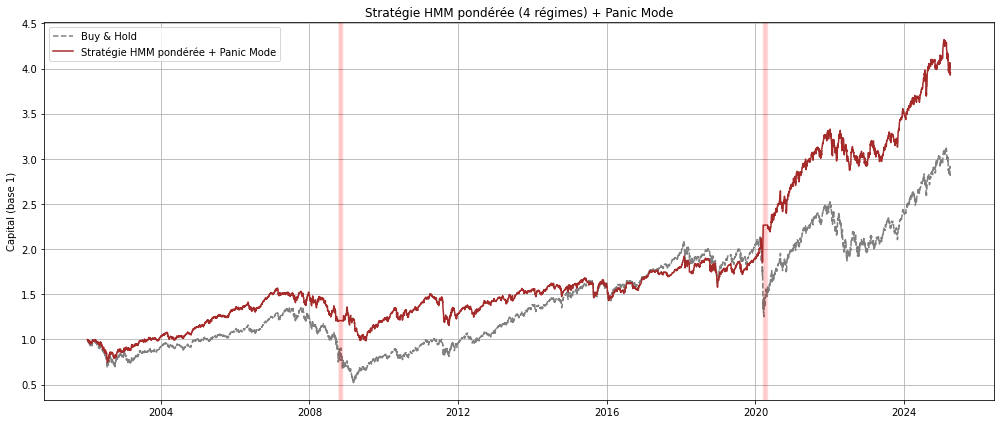


📊 Résultats finaux :
Rendement annualisé : 7.39%
Volatilité annualisée : 0.14


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm
import yfinance as yf

# 📥 Données
data = yf.download('^GSPC', start='2000-01-01', end='2025-04-01')
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)
returns = data['Log_Returns'].values.reshape(-1, 1)

# ⚙️ Paramètres
rolling_window = 500
refit_every = 3
n_states = 4

positions = []
dates = []
returns_strategy = []
panic_flags = []

model = None
remap = None
last_state = None
last_transmat = None

# Panic mode
panic_mode = False
panic_timer = 0

# 🔁 Boucle principale
for t in tqdm(range(rolling_window, len(returns) - 1), desc="📊 HMM 4 régimes + Panic Mode"):

    window_returns = returns[t - rolling_window:t]

    if (t - rolling_window) % refit_every == 0:
        try:
            model = GaussianHMM(n_components=n_states, covariance_type='full', n_iter=100)
            model.fit(window_returns)

            if np.any(model.transmat_.sum(axis=1) == 0):
                continue

            viterbi = model.predict(window_returns)
            vols = [np.var(window_returns[viterbi == i]) for i in range(n_states)]
            order = np.argsort(vols)
            remap = {old: new for new, old in enumerate(order)}
            last_state = remap[viterbi[-1]]
            last_transmat = model.transmat_[order][:, order]
        except:
            continue

    if model is None or last_transmat is None:
        continue

    # 🔍 Analyse marché récente
    rolling_vol = np.std(returns[t-20:t]) * np.sqrt(252)
    recent_return = np.mean(returns[t-5:t])

    # 🔥 Panic Mode déclenchement
    if not panic_mode and rolling_vol > 0.6 and recent_return < -0.01:
        panic_mode = True
        panic_timer = 30
        print(f"🛑 Panic mode ACTIVÉ le {data.index[t]}")

    # 🔓 Désactivation
    elif panic_mode:
        if (rolling_vol < 0.3 and recent_return > 0) or panic_timer <= 0:
            panic_mode = False
            print(f"✅ Panic mode DÉSACTIVÉ le {data.index[t]}")
        else:
            panic_timer -= 1

    # ⚖️ Position
    if panic_mode:
        pos = 0  # 🛑 full cash
        panic_flags.append(1)
    else:
        proba_next = last_transmat[last_state]
        pos = proba_next[0]*1 + proba_next[1]*0.5 + proba_next[2]*(-0.5) + proba_next[3]*(-1)
        last_state = np.argmax(proba_next)
        panic_flags.append(0)

    r_tomorrow = data['Log_Returns'].iloc[t + 1]
    returns_strategy.append(pos * r_tomorrow)
    positions.append(pos)
    dates.append(data.index[t + 1])

# 📊 Résultats
df = pd.DataFrame({
    'Date': dates,
    'Position': positions,
    'Return_Strategy': returns_strategy,
    'Panic_Mode': panic_flags
}).set_index('Date')

df['Cumulative_Strategy'] = (1 + df['Return_Strategy']).cumprod()
df['Cumulative_Market'] = (1 + data['Log_Returns'].loc[df.index]).cumprod()

# 📈 Graphe de perf + panic zone
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Cumulative_Market'], linestyle='--', color='gray', label='Buy & Hold')
plt.plot(df.index, df['Cumulative_Strategy'], color='brown', label='Stratégie HMM pondérée + Panic Mode')

for i in range(len(df)):
    if df['Panic_Mode'].iloc[i] == 1:
        plt.axvline(df.index[i], color='red', alpha=0.02)

plt.title("Stratégie HMM pondérée (4 régimes) + Panic Mode")
plt.ylabel("Capital (base 1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Statistiques finales
mean = df['Return_Strategy'].mean() * 252
vol = df['Return_Strategy'].std() * np.sqrt(252)

print("\n📊 Résultats finaux :")
print(f"Rendement annualisé : {mean:.2%}")

print(f"Volatilité annualisée : {vol:.2f}")


# benchmark ma100

[*********************100%***********************]  1 of 1 completed
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_48926/473680330.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])


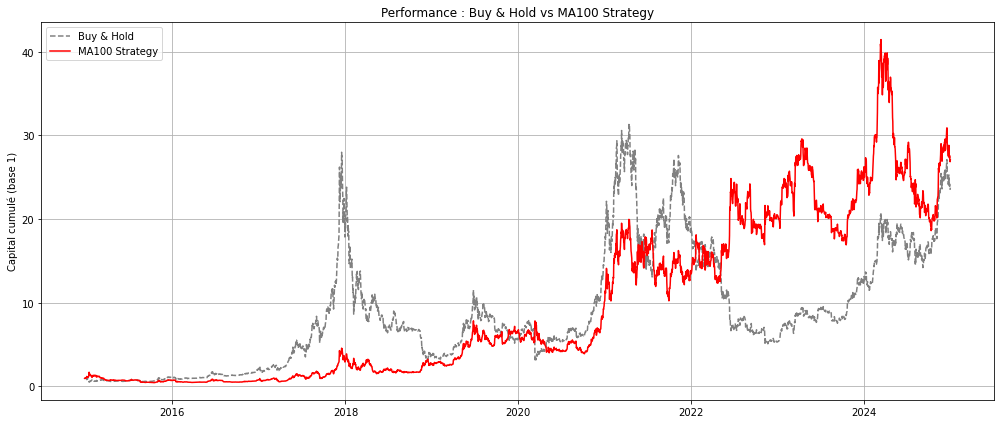

Performance MA100 Strategy :
Rendement annualisé = 39.39%
Volatilité annualisée = 57.97%
Sharpe Ratio = 0.68


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Télécharger les données BTC-USD (ou tout autre actif)
data = yf.download('BTC-USD', start='2014-01-01', end='2025-01-01')
# Calculer les log-returns
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
# Calculer la moyenne mobile sur 100 jours (MA100)
data['MA100'] = data['Close'].rolling(100).mean()
data.dropna(inplace=True)

# Générer le signal simple basé sur MA100
positions = []
dates = []
returns_strategy = []

for t in range(len(data) - 1):
    # Forcer la conversion en float pour éviter l'ambiguïté
    current_close = float(data['Close'].iloc[t])
    current_MA100 = float(data['MA100'].iloc[t])
    # Signal binaire simple : long si Close > MA100, sinon short
    if current_close > current_MA100:
        position = 1
    else:
        position = -1
    # Appliquer la position au retour du lendemain
    r_tomorrow = data['Log_Returns'].iloc[t + 1]
    positions.append(position)
    dates.append(data.index[t + 1])
    returns_strategy.append(position * r_tomorrow)

# Construire le DataFrame des résultats
df = pd.DataFrame({
    'Date': dates,
    'Position': positions,
    'Return_Strategy': returns_strategy
}).set_index('Date')

df['Cumulative_Strategy'] = (1 + df['Return_Strategy']).cumprod()
df['Cumulative_Market'] = (1 + data['Log_Returns'].loc[df.index]).cumprod()

# Graphique comparatif
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Cumulative_Market'], '--', label='Buy & Hold', color='gray')
plt.plot(df.index, df['Cumulative_Strategy'], label='MA100 Strategy', color='red')
plt.title("Performance : Buy & Hold vs MA100 Strategy")
plt.ylabel("Capital cumulé (base 1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Calcul des statistiques de performance
mean = df['Return_Strategy'].mean() * 252
vol = df['Return_Strategy'].std() * np.sqrt(252)
sharpe = mean / vol

print("Performance MA100 Strategy :")
print(f"Rendement annualisé = {mean:.2%}")
print(f"Volatilité annualisée = {vol:.2%}")
print(f"Sharpe Ratio = {sharpe:.2f}")


# HMM V1



[*********************100%***********************]  1 of 1 completed
Rolling HMM Simple à 4 états:   0%|                                                                                                                                                | 0/2210 [00:00<?, ?it/s]Model is not converging.  Current: 496.80985542903585 is not greater than 496.81259403538604. Delta is -0.0027386063501921853
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMM Simple à 4 états:   0%|▋                   

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMM Simple à 4 états:  10%|████████████▊                                                                                                                         | 211/2210 [00:01<00:20, 99.46it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(

Rolling HMM Simple à 4 états:  19%|████████████████████████▋                                                                                                            | 411/2210 [00:03<00:10, 170.02it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Model is not converging.  Current: 559.3968058386564 is not greater than 559.4125808067984. Delta is -0.01577496814195456
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single elem

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMM Simple à 4 états:  29%|███████████████████████████████████████▏                                                                                             | 651/2210 [00:04<00:08, 175.86it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(

Rolling HMM Simple à 4 états:  40%|█████████████████████████████████████████████████████                                                                                | 881/2210 [00:05<00:09, 146.62it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMM Simple à 4 états:  41%|██████████████████████████████████████████████████████▏                                                                              | 901/2210 [00:05<00:09, 139.05it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn

Rolling HMM Simple à 4 états:  50%|█████████████████████████████████████████████████████████████████▊                                                                  | 1101/2210 [00:07<00:06, 178.39it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMM Simple à 4 états:  51%|██████████████████████████████████████████████████████████████████▉                                                                 | 1121/2210 [00:07<00:06, 178.29it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn

Rolling HMM Simple à 4 états:  60%|██████████████████████████████████████████████████████████████████████████████▉                                                     | 1321/2210 [00:08<00:04, 183.96it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(

Rolling HMM Simple à 4 états:  70%|████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1551/2210 [00:09<00:04, 153.24it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMM Simple à 4 états:  71%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1571/2210 [00:09<00:03, 163.67it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn

Rolling HMM Simple à 4 états:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1771/2210 [00:10<00:01, 236.93it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ hav

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3864060814.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMM Simple à 4 états:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2011/2210 [0

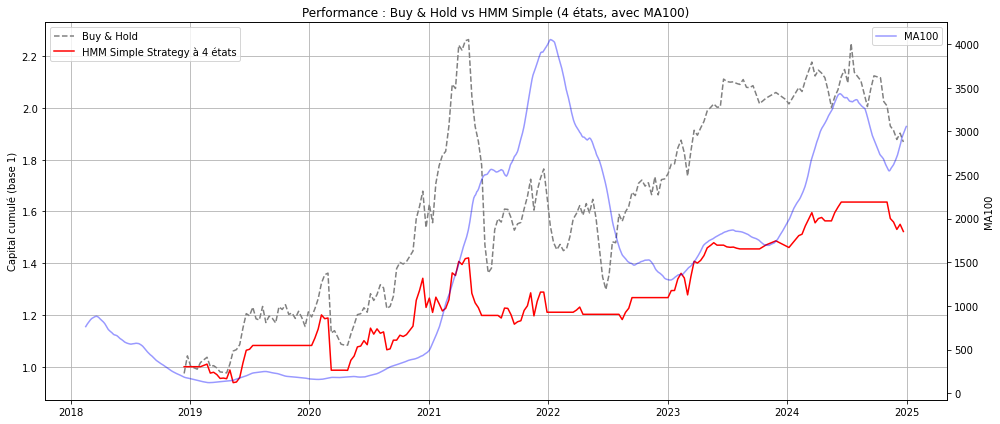

Performance HMM Simple à 4 états sur BTC-USD :
Rendement annualisé = 60.46%
Volatilité annualisée = 41.27%
Sharpe Ratio = 1.46


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm

# 1. Télécharger les données du SP500 (ici '^GSPC')
data = yf.download('ETH-USD', start='2014-01-01', end='2025-01-01')
# Utilisation du "Close" pour ce code
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
# Calcul de la MA100 pour le filtre de tendance (MA100)
data['MA100'] = data['Close'].rolling(100).mean()
data.dropna(inplace=True)
log_returns = data['Log_Returns'].values

# 2. Paramètres du rolling
window = 300    # Fenêtre pour capter rapidement la dynamique
refit_every = 10  # Réestimation plus fréquente
positions, dates, returns_strategy = [], [], []
regime_list = []

for t in tqdm(range(window, len(data) - 1), desc="Rolling HMM Simple à 4 états"):
    if (t - window) % refit_every != 0:
        continue

    window_returns = log_returns[t - window:t].reshape(-1, 1)
    model = GaussianHMM(n_components=4, covariance_type='full', n_iter=300)
    
    try:
        if np.var(window_returns) < 1e-8:
            continue
        model.fit(window_returns)
        if not np.allclose(model.transmat_.sum(axis=1), 1):
            continue
        if not np.all(np.isfinite(model.covars_)):
            continue
    except:
        continue

    # Décodeur Viterbi pour obtenir la séquence d'états sur la fenêtre
    viterbi_states = model.predict(window_returns)
    
    # Reclassification : trier les états selon leur volatilité via la trace des covariances 
    # (on considère 0 = état le moins volatil et 3 = état le plus volatil)
    if model.covars_.ndim == 3:
        vols = [np.trace(model.covars_[i]) for i in range(4)]
    else:
        vols = model.covars_.flatten()
    sorted_idx = np.argsort(vols)  
    remap = {old: new for new, old in enumerate(sorted_idx)}
    
    # On récupère l'état du dernier jour de la fenêtre et on le reclasse
    last_state_original = viterbi_states[-1]
    last_state_reclassified = remap[last_state_original]
    
    # Définition du signal selon l'état reclassé :
    # Nous définissons une échelle continue sur 4 états :
    # état 0 (calme)   -> signal = +1
    # état 1 (intermédiaire) -> signal = +0.5
    # état 2 (intermédiaire) -> signal = -0.5
    # état 3 (panique) -> signal = -1
    if last_state_reclassified == 0:
        signal = 1.0
    elif last_state_reclassified == 1:
        signal = 0.5
    elif last_state_reclassified == 2:
        signal = -0.5
    elif last_state_reclassified == 3:
        signal = -1.0
    else:
        signal = 0

    # Filtre de tendance : si le prix actuel est inférieur ou égal à la MA100, on neutralise le signal
    current_close = float(data['Close'].iloc[t])
    current_MA100 = float(data['MA100'].iloc[t])
    if current_close <= current_MA100:
        signal = 0

    r_tomorrow = log_returns[t + 1]
    positions.append(signal)
    dates.append(data.index[t + 1])
    returns_strategy.append(signal * r_tomorrow)
    regime_list.append(last_state_reclassified)

# 3. Construction du DataFrame des résultats
df = pd.DataFrame({
    'Date': dates,
    'Position': positions,
    'Return_Strategy': returns_strategy,
    'Regime': regime_list
}).set_index('Date')

df['Cumulative_Strategy'] = (1 + df['Return_Strategy']).cumprod()
df['Cumulative_Market'] = (1 + data['Log_Returns'].loc[df.index]).cumprod()

# 4. Graphique comparatif avec affichage de la MA100
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(df.index, df['Cumulative_Market'], '--', label='Buy & Hold', color='gray')
ax1.plot(df.index, df['Cumulative_Strategy'], label='HMM Simple Strategy à 4 états', color='red')
ax1.set_ylabel("Capital cumulé (base 1)")
ax1.grid(True)
ax1.legend(loc='upper left')

# Axe secondaire pour afficher la MA100
ax2 = ax1.twinx()
ax2.plot(data.index, data['MA100'], label='MA100', color='blue', alpha=0.4)
ax2.set_ylabel("MA100")
ax2.legend(loc='upper right')

plt.title("Performance : Buy & Hold vs HMM Simple (4 états, avec MA100)")
plt.tight_layout()
plt.show()

# 5. Statistiques finales
mean_simple = df['Return_Strategy'].mean() * 252
vol_simple = df['Return_Strategy'].std() * np.sqrt(252)
sharpe_simple = mean_simple / vol_simple

print("Performance HMM Simple à 4 états sur BTC-USD :")
print(f"Rendement annualisé = {mean_simple:.2%}")
print(f"Volatilité annualisée = {vol_simple:.2%}")
print(f"Sharpe Ratio = {sharpe_simple:.2f}")


# V3

[*********************100%***********************]  1 of 1 completed
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
Rolling HMMSV sur BTC-USD:   0%|                       | 0/4877 [00:00<?, ?it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:   0%|              | 11/4877 [00:00<01:57, 41.56it/s]Model is not converging.  Current: 71

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:   4%|▌            | 191/4877 [00:06<03:02, 25.62it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:   4%|▌            | 201/4877 [00:07<03:01, 25.79it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:   8%|█            | 401/4877 [00:10<01:39, 44.82it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:   8%|█            | 411/4877 [00:10<01:25, 51.93it/s]Model is not converging.  Current: 758.8269551774536 is not greater than 758.9770325393278. Delta is -0.15007736187419596
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a Ty

Rolling HMMSV sur BTC-USD:  12%|█▌           | 581/4877 [00:14<01:47, 40.01it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Rolling HMMSV sur BTC-USD:  12%|█▌           | 591/4877 [00:14<01:44, 41.14it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  12%|█▌           | 601/4877 [00:14<01:37, 43.66it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Us

Rolling HMMSV sur BTC-USD:  21%|██▍         | 1011/4877 [00:26<02:29, 25.91it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  21%|██▌         | 1021/4877 [00:26<02:28, 26.01it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  21%|██▌         | 1031/4877 [00:27<02:42, 23.71it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[

Rolling HMMSV sur BTC-USD:  25%|███         | 1241/4877 [00:32<01:32, 39.10it/s]Model is not converging.  Current: 738.8334502041677 is not greater than 739.0110451940187. Delta is -0.17759498985105893
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  26%|███         | 1251/4877 [00:33<01:31, 39.59it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  26%|███         | 1261/4877 [00:33<01:29, 40.62it/s]Model is not converging.  Current: 742.9180931139724 is not greater than 742.9348187601689. 

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  30%|███▌        | 1451/4877 [00:37<01:24, 40.49it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  30%|███▌        | 1461/4877 [00:37<01:20, 42.69it/s]Model is not converging.  Current: 775.612567389669 is not greater than 775.6281246670244. Delta is -0.015557277355355836
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a Ty

Rolling HMMSV sur BTC-USD:  34%|████        | 1641/4877 [00:43<01:28, 36.65it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  34%|████        | 1651/4877 [00:43<01:28, 36.39it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Rolling HMMSV sur BTC-USD:  34%|████        | 1661/4877 [00:43<01:25, 37.43it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Us

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  38%|████▌       | 1851/4877 [00:47<00:56, 53.26it/s]Model is not converging.  Current: 808.8781382529736 is not greater than 809.0519762701616. Delta is -0.17383801718801806
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  38%|████▌       | 1861/4877 [00:48<01:02, 48.61it/s]Model is not converging.  Current: 820.2950481380888 is not greater than 820.2982830116648. Delta is -0.003234873576047903
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/

Rolling HMMSV sur BTC-USD:  41%|████▉       | 2021/4877 [00:51<00:52, 54.72it/s]Model is not converging.  Current: 849.9129493578293 is not greater than 849.9204956597912. Delta is -0.007546301961838253
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  42%|████▉       | 2031/4877 [00:51<00:57, 49.44it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  42%|█████       | 2041/4877 [00:52<01:07, 42.15it/s]Model is not converging.  Current: 872.8948801370543 is not greater than 872.9156132704768.

Rolling HMMSV sur BTC-USD:  46%|█████▍      | 2231/4877 [00:56<01:04, 41.28it/s]Model is not converging.  Current: 923.9526741069262 is not greater than 923.9611078792373. Delta is -0.008433772311036591
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  46%|█████▌      | 2241/4877 [00:56<01:06, 39.93it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  46%|█████▌      | 2251/4877 [00:57<01:03, 41.45it/s]Model is not converging.  Current: 922.3573787031927 is not greater than 922.3675514305432.

Rolling HMMSV sur BTC-USD:  50%|█████▉      | 2431/4877 [01:01<01:05, 37.56it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  50%|██████      | 2441/4877 [01:01<01:02, 38.91it/s]Model is not converging.  Current: 786.6081630049123 is not greater than 786.612387994811. Delta is -0.004224989898716558
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  50%|██████      | 2451/4877 [01:02<01:14, 32.68it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWar

Rolling HMMSV sur BTC-USD:  54%|██████▌     | 2651/4877 [01:09<01:33, 23.93it/s]Model is not converging.  Current: 620.704604462468 is not greater than 620.7369752476345. Delta is -0.03237078516656311
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  55%|██████▌     | 2661/4877 [01:09<01:17, 28.76it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  55%|██████▌     | 2671/4877 [01:10<01:15, 29.38it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarn

Rolling HMMSV sur BTC-USD:  59%|███████     | 2871/4877 [01:17<00:40, 50.00it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  59%|███████     | 2881/4877 [01:17<00:44, 44.36it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  59%|███████     | 2891/4877 [01:17<00:42, 47.07it/s]Model is not converging.  Current: 660.6585966606818 is not greater than 660.6592595434737. Delta is -0.0006628827918575553
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureW

Rolling HMMSV sur BTC-USD:  67%|████████    | 3281/4877 [01:29<01:22, 19.45it/s]Model is not converging.  Current: 824.3915979408328 is not greater than 824.4074704732969. Delta is -0.015872532464186406
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  67%|████████    | 3291/4877 [01:29<01:05, 24.34it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Rolling HMMSV sur BTC-USD:  68%|████████    | 3301/4877 [01:29<00:52, 29.76it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/244561660

Rolling HMMSV sur BTC-USD:  72%|████████▌   | 3501/4877 [01:38<00:36, 37.43it/s]Model is not converging.  Current: 754.7514720451466 is not greater than 754.7890815022602. Delta is -0.03760945711360364
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  72%|████████▋   | 3511/4877 [01:38<00:38, 35.65it/s]Model is not converging.  Current: 752.8961504914892 is not greater than 752.8991492477711. Delta is -0.002998756281954229
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  72%|████████▋   | 352

Rolling HMMSV sur BTC-USD:  76%|█████████▏  | 3711/4877 [01:42<00:21, 53.17it/s]Model is not converging.  Current: 637.9916604981613 is not greater than 638.019430832064. Delta is -0.027770333902708444
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  76%|█████████▏  | 3721/4877 [01:42<00:20, 56.64it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  77%|█████████▏  | 3731/4877 [01:43<00:17, 64.78it/s]Model is not converging.  Current: 622.657490459349 is not greater than 622.6617224801846. D

Rolling HMMSV sur BTC-USD:  81%|█████████▋  | 3931/4877 [01:51<01:01, 15.35it/s]Model is not converging.  Current: 598.6708375053895 is not greater than 598.6712809150519. Delta is -0.0004434096623526784
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  81%|█████████▋  | 3941/4877 [01:52<00:54, 17.10it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  81%|█████████▋  | 3951/4877 [01:52<00:50, 18.30it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureW

Rolling HMMSV sur BTC-USD:  85%|██████████▏ | 4151/4877 [02:01<00:23, 31.04it/s]Model is not converging.  Current: 750.7959573436223 is not greater than 750.8317457446572. Delta is -0.03578840103489256
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  85%|██████████▏ | 4161/4877 [02:01<00:19, 35.87it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  86%|██████████▎ | 4171/4877 [02:01<00:21, 33.55it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWar

Rolling HMMSV sur BTC-USD:  94%|███████████▎| 4591/4877 [02:12<00:05, 55.82it/s]Model is not converging.  Current: 712.3188520669663 is not greater than 712.3205807439296. Delta is -0.0017286769632391952
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  95%|███████████▎| 4611/4877 [02:13<00:03, 68.29it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a 

Rolling HMMSV sur BTC-USD:  98%|███████████▊| 4801/4877 [02:17<00:01, 39.72it/s]Model is not converging.  Current: 771.3367410841056 is not greater than 771.3438411507213. Delta is -0.007100066615748801
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  99%|███████████▊| 4811/4877 [02:17<00:01, 41.37it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_51300/2445616600.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV sur BTC-USD:  99%|███████████▊| 4821/4877 [02:18<00:01, 35.25it/s]Model is not converging.  Current: 758.0706751078789 is not greater than 758.3774484638591.

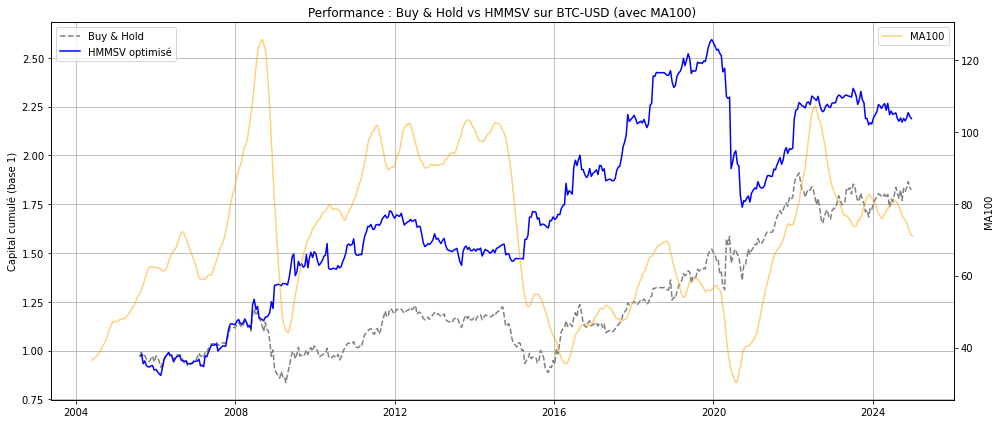

Performance HMMSV optimisé sur BTC-USD :
Rendement annualisé = 48.00%
Volatilité annualisée = 33.66%
Sharpe Ratio = 1.43
Volatilité prévisionnelle (moyenne pondérée) = 0.0101


In [24]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

# 1. Télécharger les données BTC-USD (Bitcoin)
data = yf.download('CL=F', start='2004-01-01', end='2025-01-01')
# Utilisation du "Close" pour ce code
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
# Calcul de la moyenne mobile sur 100 jours pour le filtre de tendance (MA100)
data['MA100'] = data['Close'].rolling(100).mean()
data.dropna(inplace=True)
log_returns = data['Log_Returns'].values

# 2. Paramètres du rolling
window = 300    # Fenêtre plus courte pour capter rapidement la dynamique
refit_every = 10  # Réestimation plus fréquente pour suivre les changements
positions, dates, returns_strategy = [], [], []
regimes_rolling = []

# Boucle rolling sur les données
for t in tqdm(range(window, len(data) - 1), desc="Rolling HMMSV sur BTC-USD"):
    
    if (t - window) % refit_every != 0:
        continue
    
    window_returns = log_returns[t - window:t].reshape(-1, 1)
    model = GaussianHMM(n_components=3, covariance_type='full', n_iter=300)
    
    try:
        if np.var(window_returns) < 1e-8:
            continue
        model.fit(window_returns)
        if not np.allclose(model.transmat_.sum(axis=1), 1):
            continue
        if not np.all(np.isfinite(model.covars_)):
            continue
    except:
        continue

    # Obtenir les probabilités d'état sur la fenêtre et retenir celle du dernier jour
    proba = model.predict_proba(window_returns)
    last_proba = proba[-1]
    
    # Reclasser dynamiquement les états en fonction de la volatilité (trace des covariances)
    if model.covars_.ndim == 3:
        vols = [np.trace(model.covars_[i]) for i in range(3)]
    else:
        vols = model.covars_.flatten()
    sorted_idx = np.argsort(vols)  # On suppose : 0 = état de faible volatilité (calme), 2 = état de forte volatilité (panique)
    remap = {old: new for new, old in enumerate(sorted_idx)}
    reordered_proba = np.zeros(3)
    for i in range(3):
        reordered_proba[remap[i]] = last_proba[i]
    
    # -------------------------
    # Ajout de la modélisation AR(1) pour une dynamique de volatilité (HMMSV)
    #
    # On estime pour chaque état i un AR(1) sur log(R²) dans la fenêtre.
    # On utilise une condition sur la probabilité (par exemple, proba > 0.5) pour sélectionner les périodes appartenant à cet état.
    log_r2 = np.log(window_returns.flatten()**2 + 1e-8)
    sigma_states = np.zeros(3)
    for i in range(3):
        idx = np.where(proba[:, i] > 0.5)[0]
        if len(idx) < 3:
            sigma_states[i] = np.nan
        else:
            y_ar = log_r2[idx]
            x_ar = np.roll(y_ar, 1)[1:]
            y_ar_fit = y_ar[1:]
            model_ar = LinearRegression().fit(x_ar.reshape(-1, 1), y_ar_fit)
            phi = model_ar.coef_[0]
            mu = model_ar.intercept_ / (1 - phi)
            h_ar = np.zeros(len(idx))
            h_ar[0] = mu
            for j in range(1, len(idx)):
                # Si les indices sont consécutifs, on propage via AR(1), sinon on réinitialise
                if idx[j] == idx[j-1] + 1:
                    h_ar[j] = mu + phi * (h_ar[j-1] - mu)
                else:
                    h_ar[j] = mu
            sigma_states[i] = np.exp(h_ar[-1] / 2)  # Volatilité prévisionnelle pour cet état

    # Calcul de la volatilité globale prévisionnelle comme moyenne pondérée des sigma_states,
    # en utilisant les probabilités reclassées (si certaines valeurs sont NaN, on les ignore)
    valid = ~np.isnan(sigma_states)
    if np.sum(valid) > 0:
        sigma_weighted = np.sum(reordered_proba[valid]*sigma_states[valid]) / np.sum(reordered_proba[valid])
    else:
        sigma_weighted = 0.02  # valeur par défaut

    # -------------------------
    # Filtre de tendance : comparer le Close et le MA100 (conversion en float)
    current_close = float(data['Close'].iloc[t])
    current_MA100 = float(data['MA100'].iloc[t])
    if current_close > current_MA100:
        # Tendance haussière : booster l'exposition long et atténuer le short
        long_weight = 2.0
        short_weight = -0.25
    else:
        # Tendance baissière : réduire l'exposition long et rester agressif short
        long_weight = 0.75
        short_weight = -1.0

    # Signal issu du HMM de base (pondéré) :
    hmm_signal = reordered_proba[0] * long_weight + reordered_proba[2] * short_weight
    # Optionnellement, on peut moduler le signal en fonction de la volatilité prévisionnelle.
    # Par exemple, si la volatilité prévisionnelle est trop élevée, réduire l'exposition.
    threshold = 0.03  # Par exemple, 3% de volatilité journalier attendue
    if sigma_weighted > threshold:
        final_signal = hmm_signal * 0.5  # réduction de l'exposition si vol trop élevée
    else:
        final_signal = hmm_signal

    # -------------------------
    r_tomorrow = log_returns[t + 1]
    positions.append(final_signal)
    dates.append(data.index[t + 1])
    returns_strategy.append(final_signal * r_tomorrow)
    regimes_rolling.append(np.argmax(reordered_proba))

# 3. Construction du DataFrame des résultats
df = pd.DataFrame({
    'Date': dates,
    'Position': positions,
    'Return_Strategy': returns_strategy,
    'Regime': regimes_rolling
}).set_index('Date')

df['Cumulative_Strategy'] = (1 + df['Return_Strategy']).cumprod()
df['Cumulative_Market'] = (1 + data['Log_Returns'].loc[df.index]).cumprod()

# 4. Graphique comparatif avec affichage de la MA100
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(df.index, df['Cumulative_Market'], '--', label='Buy & Hold', color='gray')
ax1.plot(df.index, df['Cumulative_Strategy'], label='HMMSV optimisé', color='blue')
ax1.set_ylabel("Capital cumulé (base 1)")
ax1.grid(True)
ax1.legend(loc='upper left')

# Axe secondaire pour afficher la MA100
ax2 = ax1.twinx()
ax2.plot(data.index, data['MA100'], label='MA100', color='orange', alpha=0.5)
ax2.set_ylabel("MA100")
ax2.legend(loc='upper right')

plt.title("Performance : Buy & Hold vs HMMSV sur BTC-USD (avec MA100)")
plt.tight_layout()
plt.show()

# 5. Statistiques finales
mean = df['Return_Strategy'].mean() * 252
vol = df['Return_Strategy'].std() * np.sqrt(252)
sharpe = mean / vol

print("Approximate SV-HMM with rolling volatility-adjusted HMM probabilities and AR(1)-based volatility forecast")
print(f"Rendement annualisé = {mean:.2%}")
print(f"Volatilité annualisée = {vol:.2%}")
print(f"Sharpe Ratio = {sharpe:.2f}")
print(f"Volatilité prévisionnelle (moyenne pondérée) = {sigma_weighted:.4f}")


# V3 MODIF

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
Rolling HMMSV avec filtre MA100:   0%|                                                                                                                                             | 0/2364 [00:00<?, ?it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV avec filtre MA100:   0%|                                                                                                                                     | 1/2364 [00:00<30:42,  1.28it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_653

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV avec filtre MA100:  10%|████████████▋                                                                                                                     | 231/2364 [0

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV avec filtre MA100:  19%|████████████████████████▊                                                                                                         | 451/2364 [00:02<00:09, 207.22it/s]Model is not converging.  Current: 725.9031397959719 is not greater than 725.9492129668544. Delta is -0.0460731708824369
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single eleme

Rolling HMMSV avec filtre MA100:  27%|███████████████████████████████████▏                                                                                              | 641/2364 [00:03<00:06, 247.21it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:386: RuntimeWarning: overflow encountered in true_divide
  self._covars_ = ((covars_prior + c_n) /
Model is not converging.  Current: 823.2387976836714 is not greater than 823.3956264697855. Delta is -0.15682878611414708
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Model is not converging.  Current: 781.3742451998563 is not greater than 781.3974035357668. Delta is -0.02315833591046612
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV avec filtre MA100:  37%|███████████████████████████████████████████████▉                                                                                  | 871/2364 [00:04<00:05, 284.25it/s]Model is not converging.  Current: 777.0037206321156 is not greater than 777.0053304342808. Delta is -0.0016098021652624084
/var

Rolling HMMSV avec filtre MA100:  45%|██████████████████████████████████████████████████████████▏                                                                      | 1066/2364 [00:05<00:07, 176.88it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(

Rolling HMMSV avec filtre MA100:  54%|█████████████████████████████████████████████████████████████████████▎                                                           | 1271/2364 [00:06<00:05, 186.48it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV avec filtre MA100:  55%|██████████████████████████████████████████████████████████████████████▌                                                          | 1292/2364 [00:06<00:06, 173.39it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn

Model is not converging.  Current: 697.9395299934544 is not greater than 697.9524484548447. Delta is -0.012918461390313496
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV avec filtre MA100:  64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 1511/2364 [00:07<00:03, 260.45it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single ele

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV avec filtre MA100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1721/2364 [00:08<00:03, 199.16it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV avec filtre MA100:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1971/2364 [00:09<00:01, 228.41it/s]Model is not converging.  Current: 670.9212949154862 is not greater than 670.9226926992293. Delta is -0.0013977837430729778
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single el

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Rolling HMMSV avec filtre MA100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2171/2364 [00:10<00:00, 300.11it/s]Model is not converging.  Current: 740.7314129369616 is not greater than 740.7501536677844. Delta is -0.01874073082274208
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/3839994625.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data['Close'].iloc[t])
Model is not converging.  Current: 749.7220768296087 is not greater than 749.92748643476. Delta is -0.205409605151317
/var/folde

Rolling HMMSV avec filtre MA100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2364/2364 [00:10<00:00, 217.92it/s]


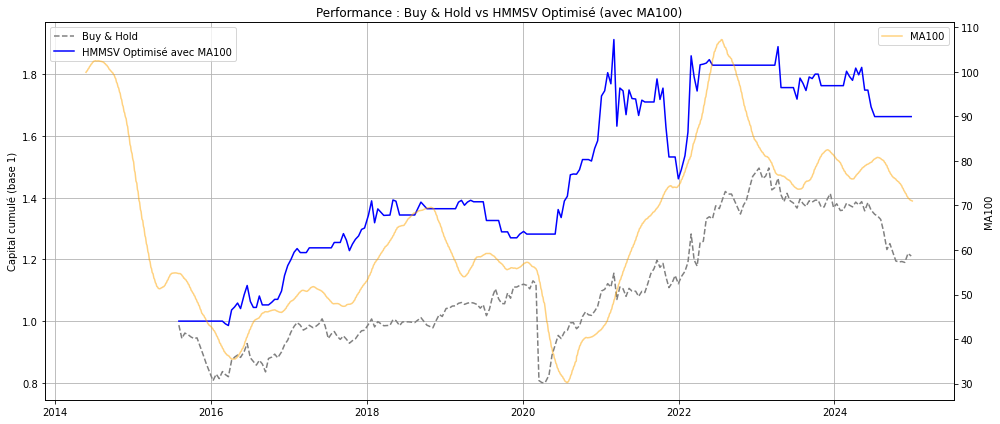

Performance HMMSV Optimisé avec MA100 sur BTC-USD :
Rendement annualisé = 64.86%
Volatilité annualisée = 40.84%
Sharpe Ratio = 1.59


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm

# 1. Télécharger les données du SP500 (ici '^GSPC')
data = yf.download('CL=F', start='2014-01-01', end='2025-01-01')
# Utilisation du "Close" pour ce code
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
# Calcul de la MA100 pour le filtre de tendance (MA100)
data['MA100'] = data['Close'].rolling(100).mean()
data.dropna(inplace=True)
log_returns = data['Log_Returns'].values

# 2. Paramètres du rolling
window = 300   # Fenêtre pour capter rapidement la dynamique
refit_every = 10  # Réestimation plus fréquente
positions, dates, returns_strategy, regime_list = [], [], [], []

# Paramètres pour la modulation de volatilité
vol_threshold = 0.03         # Seuil de volatilité attendu (exemple: 3% de volatilité journalière)
modulation_factor = 0.5      # Facteur de réduction de signal si volatilité trop forte
epsilon = 1e-8               # Petite constante pour éviter log(0)

for t in tqdm(range(window, len(data)-1), desc="Rolling HMMSV avec filtre MA100"):
    if (t - window) % refit_every != 0:
        continue

    # Extraction de la fenêtre d'observations
    window_returns = log_returns[t-window:t].reshape(-1, 1)
    
    # Ajustement de l'HMM (ici avec 3 états)
    model = GaussianHMM(n_components=3, covariance_type='full', n_iter=300)
    try:
        if np.var(window_returns) < 1e-8:
            continue
        model.fit(window_returns)
        if not np.allclose(model.transmat_.sum(axis=1), 1):
            continue
        if not np.all(np.isfinite(model.covars_)):
            continue
    except:
        continue
    
    # Extraction des probabilités d'appartenance via predict_proba
    proba = model.predict_proba(window_returns)
    last_proba = proba[-1]
    
    # Reclassification des états en fonction de la volatilité
    if model.covars_.ndim == 3:
        vols = [np.trace(model.covars_[i]) for i in range(3)]
    else:
        vols = model.covars_.flatten()
    sorted_idx = np.argsort(vols)  # ordre croissant: 0 = état le moins volatil, 2 = état le plus volatil
    remap = {old: new for new, old in enumerate(sorted_idx)}
    reordered_proba = np.zeros(3)
    for i in range(3):
        reordered_proba[remap[i]] = last_proba[i]
    
    # Construction du signal de base à partir des probabilités
    # On assume que :
    # - l'état 0 correspond à un régime "calme" (signal haussier),
    # - l'état 2 correspond à un régime "panique" (signal baissier),
    # et on ignore l'état intermédiaire (signal pondéré par 0).
    # Le choix des poids dépend de la tendance du marché observée.
    current_close = float(data['Close'].iloc[t])
    current_MA100 = float(data['MA100'].iloc[t])
    if current_close > current_MA100:
        w_long = 2.0
        w_short = -0.25
    else:
        w_long = 0.75
        w_short = -1.0
    signal_base = reordered_proba[0]*w_long + reordered_proba[2]*w_short
    
    # Estimation dynamique de la volatilité par un modèle AR(1) sur log(r^2)
    log_sq = np.log(window_returns**2 + epsilon)
    # Construction des paires (lag 1) pour ajuster y_t = phi * y_{t-1} + c
    X = log_sq[:-1].flatten()
    Y = log_sq[1:].flatten()
    try:
        phi, c = np.polyfit(X, Y, 1)
    except:
        continue
    h_last = log_sq[-1, 0]
    sigma_forecast = np.exp(h_last/2)
    
    # Modulation du signal par la volatilité prévue
    if sigma_forecast > vol_threshold:
        signal_modulated = signal_base * modulation_factor
    else:
        signal_modulated = signal_base
    
    # Application du filtre MA100: si le prix actuel est inférieur ou égal à la MA100, 
    # on neutralise le signal
    if current_close <= current_MA100:
        signal_final = 0
    else:
        signal_final = signal_modulated
    
    # Calcul du rendement du jour suivant et enregistrement du signal
    r_tomorrow = log_returns[t+1]
    positions.append(signal_final)
    dates.append(data.index[t+1])
    returns_strategy.append(signal_final * r_tomorrow)
    regime_list.append(np.argmax(reordered_proba))

# 3. Construction du DataFrame des résultats
df = pd.DataFrame({
    'Date': dates,
    'Position': positions,
    'Return_Strategy': returns_strategy,
    'Regime': regime_list
}).set_index('Date')

df['Cumulative_Strategy'] = (1 + df['Return_Strategy']).cumprod()
df['Cumulative_Market'] = (1 + data['Log_Returns'].loc[df.index]).cumprod()

# 4. Graphique comparatif avec affichage de la MA100
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(df.index, df['Cumulative_Market'], '--', label='Buy & Hold', color='gray')
ax1.plot(df.index, df['Cumulative_Strategy'], label='HMMSV Optimisé avec MA100', color='blue')
ax1.set_ylabel("Capital cumulé (base 1)")
ax1.grid(True)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(data.index, data['MA100'], label='MA100', color='orange', alpha=0.5)
ax2.set_ylabel("MA100")
ax2.legend(loc='upper right')

plt.title("Performance : Buy & Hold vs HMMSV Optimisé (avec MA100)")
plt.tight_layout()
plt.show()

# 5. Statistiques finales
mean_model3 = np.mean(df['Return_Strategy']) * 252
vol_model3 = np.std(df['Return_Strategy']) * np.sqrt(252)
sharpe_model3 = mean_model3 / vol_model3

print("Performance HMMSV Optimisé avec MA100 sur BTC-USD :")
print(f"Rendement annualisé = {mean_model3:.2%}")
print(f"Volatilité annualisée = {vol_model3:.2%}")
print(f"Sharpe Ratio = {sharpe_model3:.2f}")


# V2

In [5]:
print("Shape du DataFrame :", data.shape)
print(data.head())

Shape du DataFrame : (0, 6)
Empty DataFrame
Columns: [(Adj Close, CL=F), (Close, CL=F), (High, CL=F), (Low, CL=F), (Open, CL=F), (Volume, CL=F)]
Index: []


Rolling HMM Optimisé:   0%|                                                                                                                                                        | 0/5287 [00:00<?, ?it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Rolling HMM Optimisé:   1%|█▋                                                                                                                                            | 61/5287 [00:00<00:23, 219.13it/s]Model is not converging.  Current: 3133.217903971512 is not greater than 3133.250625283779. Delta is -0.03272131226685815
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * m

Rolling HMM Optimisé:  43%|████████████████████████████████████████████████████████████▍                                                                               | 2281/5287 [00:13<00:12, 236.34it/s]Model is not converging.  Current: 3394.102748534707 is not greater than 3395.134746860969. Delta is -1.0319983262616006
Model is not converging.  Current: 3386.8967954271006 is not greater than 3386.9499686569807. Delta is -0.053173229880030703
Rolling HMM Optimisé:  45%|██████████████████████████████████████████████████████████████▊                                                                             | 2371/5287 [00:13<00:14, 204.51it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Rolling HMM Optimisé:  46%|████████████████████████

Rolling HMM Optimisé:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 4081/5287 [00:23<00:06, 190.03it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Model is not converging.  Current: 3394.1437537769352 is not greater than 3394.1735963574442. Delta is -0.029842580509011896
Rolling HMM Optimisé:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4261/5287 [00:23<00:04, 212.90it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from

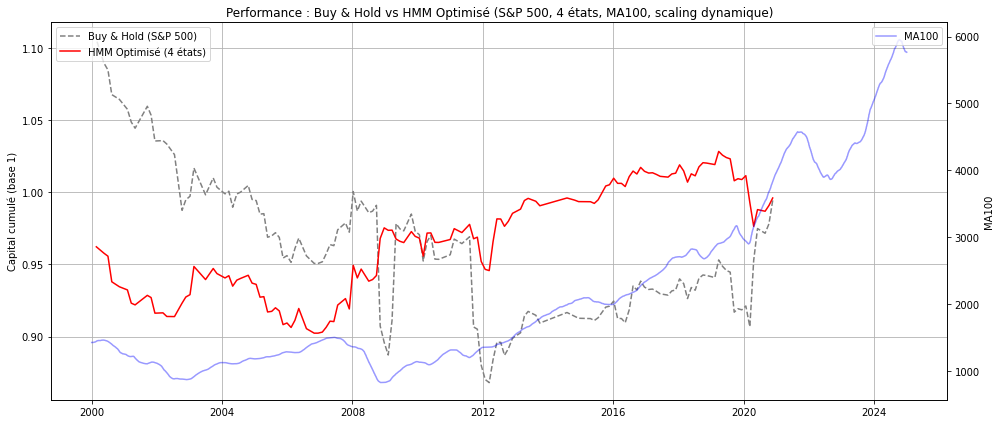

📊 Performance HMM Optimisé sur S&P 500 :
Rendement annualisé = -6.23%
Volatilité annualisée = 12.19%
Sharpe Ratio = -0.51
Max Drawdown = -12.25%


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm

# 1. Chargement des données depuis fichier local (Stooq)
data = pd.read_csv("/Users/jeremy.duriez/Desktop/^spx_d.csv")
data = data[::-1]
data = data.rename(columns=str.strip)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[data.index >= '2000-01-01']

# 2. Calcul des log-returns et MA100
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['MA100'] = data['Close'].rolling(100).mean()
data.dropna(inplace=True)
log_returns = data['Log_Returns'].values

# 3. Paramètres de la stratégie
window = 1000
refit_every = 30
positions, dates, returns_strategy, regime_list = [], [], [], []

for t in tqdm(range(window, len(data) - 1), desc="Rolling HMM Optimisé"):
    if (t - window) % refit_every != 0:
        continue

    window_returns = log_returns[t - window:t].reshape(-1, 1)
    model = GaussianHMM(n_components=4, covariance_type='full', n_iter=500)

    try:
        if np.var(window_returns) < 1e-8:
            continue
        model.fit(window_returns)
        if not np.allclose(model.transmat_.sum(axis=1), 1):
            continue
        if not np.all(np.isfinite(model.covars_)):
            continue
    except:
        continue

    proba = model.predict_proba(window_returns)
    last_proba = proba[-1]

    # Reclassement des régimes selon la volatilité
    if model.covars_.ndim == 3:
        vols = [np.trace(model.covars_[i]) for i in range(4)]
    else:
        vols = model.covars_.flatten()
    sorted_idx = np.argsort(vols)
    remap = {old: new for new, old in enumerate(sorted_idx)}

    reordered_proba = np.zeros(4)
    for i in range(4):
        reordered_proba[remap[i]] = last_proba[i]

    # Signal pondéré par proba et régimes
    signal_continuous = (
        +1.0 * reordered_proba[0] +
        +0.5 * reordered_proba[1] +
        -0.5 * reordered_proba[2] +
        -1.0 * reordered_proba[3]
    )

    # Ajustement selon la tendance (MA100)
    current_close = float(data['Close'].iloc[t])
    current_MA100 = float(data['MA100'].iloc[t])
    if current_close > current_MA100:
        signal_final = signal_continuous * 1.2
    else:
        signal_final = signal_continuous * 0.7

    # Ajustement selon la volatilité récente (risk control)
    recent_vol = np.std(log_returns[t - 20:t])
    if recent_vol > 0.02:
        signal_final *= 0.5

    r_tomorrow = log_returns[t + 1]
    positions.append(signal_final)
    dates.append(data.index[t + 1])
    returns_strategy.append(signal_final * r_tomorrow)
    regime_list.append(np.argmax(reordered_proba))

# 4. Résultats
df = pd.DataFrame({
    'Date': dates,
    'Position': positions,
    'Return_Strategy': returns_strategy,
    'Regime': regime_list
}).set_index('Date')

df['Cumulative_Strategy'] = (1 + df['Return_Strategy']).cumprod()
df['Cumulative_Market'] = (1 + data['Log_Returns'].loc[df.index]).cumprod()

# 5. Visualisation
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(df.index, df['Cumulative_Market'], '--', label='Buy & Hold (S&P 500)', color='gray')
ax1.plot(df.index, df['Cumulative_Strategy'], label='HMM Optimisé (4 états)', color='red')
ax1.set_ylabel("Capital cumulé (base 1)")
ax1.grid(True)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(data.index, data['MA100'], label='MA100', color='blue', alpha=0.4)
ax2.set_ylabel("MA100")
ax2.legend(loc='upper right')

plt.title("Performance : Buy & Hold vs HMM Optimisé (S&P 500, 4 états, MA100, scaling dynamique)")
plt.tight_layout()
plt.show()

# 6. Statistiques
mean = df['Return_Strategy'].mean() * 252
vol = df['Return_Strategy'].std() * np.sqrt(252)
sharpe = mean / vol
drawdown = (df['Cumulative_Strategy'] / df['Cumulative_Strategy'].cummax() - 1).min()

print("📊 Performance HMM Optimisé sur S&P 500 :")
print(f"Rendement annualisé = {mean:.2%}")
print(f"Volatilité annualisée = {vol:.2%}")
print(f"Sharpe Ratio = {sharpe:.2f}")
print(f"Max Drawdown = {drawdown:.2%}")


# SVHMM volatility forecast 

[*********************100%***********************]  1 of 1 completed
Rolling SV‑HMM:   0%|                                                                                                                                                              | 0/4884 [00:00<?, ?it/s]Model is not converging.  Current: 689.6162610704761 is not greater than 689.6281737314922. Delta is -0.011912661016140191
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 684.5814409229816 is not greater than 684.5970502237803. Delta is -0.015609300798701042
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) 

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:   5%|██████▋                                                                                                                                            | 221/4884 [00:00<00:17, 272.15it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 689.2484537815369 is not greater than 689.2562310699273. Delta is -0.007777288390343529
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is depr

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:   9%|█████████████▎                                                                                                                                     | 441/4884 [00:01<00:16, 264.56it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Roll

Rolling SV‑HMM:  13%|███████████████████▌                                                                                                                               | 652/4884 [00:02<00:22, 186.58it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  14%|████████████████████▏                                                                                                                              | 671/4884 [00:02<00:24, 175.48it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  18%|██████████████████████████▊                                                                                                                        | 891/4884 [00:03<00:18, 220.33it/s]Model is not converging.  Current: 601.8929656362965 is not greater than 601.9017868902285. Delta is -0.00882125393206934
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is depre

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  23%|█████████████████████████████████▌                                                                                                                | 1121/4884 [00:04<00:15, 239.47it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Mode

[t=1510 2010-05-26] HMM fit failed: array must not contain infs or NaNs


/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  26%|██████████████████████████████████████▎                                                                                                           | 1281/4884 [00:05<00:11, 311.40it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Mode

[t=1680 2011-01-27] HMM fit failed: array must not contain infs or NaNs


Model is not converging.  Current: 831.8632140909639 is not greater than 831.9988385354193. Delta is -0.13562444445540223
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  30%|███████████████████████████████████████████▍                                                                                                      | 1451/4884 [00:05<00:10, 334.24it/s]Model is not converging.  Current: 834.5982171462249 is not greater than 834.6399315782643. Delta is -0.04171443203938452
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.

[t=1800 2011-07-20] HMM fit failed: array must not contain infs or NaNs


Model is not converging.  Current: 826.1573368115875 is not greater than 826.168584721405. Delta is -0.01124790981748447
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  32%|███████████████████████████████████████████████▍                                                                                                  | 1585/4884 [00:06<00:10, 304.11it/s]Model is not converging.  Current: 820.4746168238058 is not greater than 820.5231386088043. Delta is -0.048521784998456496
/var/folders/vw/zzmp8l0n

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  36%|████████████████████████████████████████████████████▉                                                                                             | 1771/4884 [00:06<00:09, 319.17it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 796.1385554003482 is not greater than 796.431047934297. Delta is -0.2924925339488027
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a s

[t=2080 2012-08-28] HMM fit failed: array must not contain infs or NaNs


Model is not converging.  Current: 786.846801564968 is not greater than 786.8516947238192. Delta is -0.004893158851132284
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  38%|███████████████████████████████████████████████████████▎                                                                                          | 1851/4884 [00:07<00:09, 313.86it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a

[t=2160 2012-12-24] HMM fit failed: array must not contain infs or NaNs


Model is not converging.  Current: 772.4298731227855 is not greater than 772.459587167448. Delta is -0.029714044662568995
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 772.7970455285748 is not greater than 772.8195822802945. Delta is -0.02253675171971281
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p

[t=2340 2013-09-12] HMM fit failed: transmat_ rows must sum to 1 (got row sums of [0. 1. 1.])


Model is not converging.  Current: 779.3292414307351 is not greater than 779.3602012388255. Delta is -0.03095980809041521
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 787.7485830177479 is not greater than 787.8589903330341. Delta is -0.11040731528612469
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 793.6253955593352 is not greater than 793.6311527156178. Delta is -0.005757156282584219
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling 

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 885.2709572964939 is not greater than 885.492026853352. Delta is -0.22106955685808316
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  48%|█████████████████████████████████████████████████████████████████████▋                                                                            | 2331/4884 [00:08<00:07, 326.15it/s]Model is not converging.  Current: 885.3668356042502 is not greater than 885.4666465884019. Delta is -0.09981098415164524
/var/folders/vw/zzmp8l0n2

[t=2610 2014-10-08] HMM fit failed: transmat_ rows must sum to 1 (got row sums of [1. 1. 0.])


/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 883.6016786915299 is not greater than 883.7061792520834. Delta is -0.10450056055356072
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 869.2141409665937 is not greater than 869.253065552405. Delta is -0.038924585811287216
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p

[t=2800 2015-07-13] HMM fit failed: array must not contain infs or NaNs
[t=2820 2015-08-10] HMM fit failed: transmat_ rows must sum to 1 (got row sums of [1. 1. 0.])


/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 810.2596988631215 is not greater than 810.307744591577. Delta is -0.048045728455576864
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 818.1334887626416 is

[t=2870 2015-10-20] HMM fit failed: array must not contain infs or NaNs


Model is not converging.  Current: 792.3423897398296 is not greater than 792.3488824632634. Delta is -0.0064927234337801565
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 795.0227785712522 is not greater than 795.1882096295093. Delta is -0.165431058257127
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 794.8327569019532 is not greater than 794.8373690266723. Delta is -0.004612124719074018
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling 

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 2844/4884 [00:10<00:06, 321.54it/s]/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


[t=3090 2016-09-02] HMM fit failed: array must not contain infs or NaNs
[t=3150 2016-11-29] HMM fit failed: array must not contain infs or NaNs


Model is not converging.  Current: 836.4570428272501 is not greater than 836.4674351979836. Delta is -0.010392370733484313
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 844.6868301533577 is not greater than 844.7065443924455. Delta is -0.019714239087761598
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  59%|██████████████████████████████████████████████████████████████████████████████████████                                                            | 2877/4884 [00:10<00:06, 315.07it/s]Model is not convergin

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3051/4884 [00:11<00:05, 315.23it/s]Model is not converging.  Current: 931.398169875016 is not greater than 931.7290787300093. Delta is -0.33090885499325395
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 945.4579340986148 is not greater than 946.942789700553. Delta is -1.484855601938193
/var/folders/vw/zzmp8l0n22df

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3241/4884 [00:11<00:04, 344.59it/s]Model is not converging.  Current: 876.5675998291978 is not greater than 876.8000612140286. Delta is -0.23246138483079903
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 876.9205611088943 is not greater than 877.1756341378367. Delta is -0.25507302894243367
/var/folders/vw/zzmp8l0n

[t=3620 2018-10-11] HMM fit failed: array must not contain infs or NaNs
[t=3650 2018-11-23] HMM fit failed: array must not contain infs or NaNs
[t=3670 2018-12-24] HMM fit failed: array must not contain infs or NaNs


/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3391/4884 [00:12<00:04, 312.58it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 781.7664106117988 is not greater than 781.9101266296116. Delta is -0.14371601781272147
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is depre

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 772.9811840682504 is not greater than 772.9881965919147. Delta is -0.007012523664343462
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3601/4884 [00:12<00:04, 293.76it/s]Model is not converging.  Current: 782.4995705007395 is not greater than 782.5757770429218. Delta is -0.07620654218226264
/var/folders/vw/zzmp8l0

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3802/4884 [00:13<00:03, 298.52it/s]Model is not converging.  Current: 731.23966947604 is not greater than 731.3172240243531. Delta is -0.07755454831305997
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is depreca

Rolling SV‑HMM:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4011/4884 [00:14<00:03, 275.46it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 744.5412179128458 is not greater than 744.5422138184434. Delta is -0.0009959055976196396
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 750.1206103091679 is not greater than 750.1606161590037. Delta is -0.04000584983577937
/var/folders/vw/zzmp8l

[t=4360 2021-09-21] HMM fit failed: array must not contain infs or NaNs


/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4142/4884 [00:14<00:02, 264.60it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/4

[t=4430 2021-12-30] HMM fit failed: transmat_ rows must sum to 1 (got row sums of [0. 1. 1.])


Model is not converging.  Current: 809.0980944962226 is not greater than 809.1099723055564. Delta is -0.011877809333782352
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 815.0407607423431 is not greater than 815.0702852913106. Delta is -0.02952454896751533
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 810.7819558605585 is not greater than 810.788586591124. Delta is -0.0066307305655755044
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling

/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 723.0578790652085 is not greater than 723.1533413515081. Delta is -0.09546228629960751
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4411/4884 [00:15<00:01, 325.46it/s]/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is depre

[t=4730 2023-03-13] HMM fit failed: array must not contain infs or NaNs
[t=4760 2023-04-25] HMM fit failed: array must not contain infs or NaNs


Model is not converging.  Current: 746.3188043150009 is not greater than 746.3305639112497. Delta is -0.011759596248793969
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/Users/jeremy.duriez/opt/anaconda3/lib/python3.9/site-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  93%|█████████████████████████████████

[t=4820 2023-07-21] HMM fit failed: array must not contain infs or NaNs


/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 812.7402551691729 is not greater than 812.788558857582. Delta is -0.04830368840907795
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Rolling SV‑HMM:  94%|██████████████████████████████████████████████████████████████████

[t=4970 2024-02-26] HMM fit failed: array must not contain infs or NaNs


Model is not converging.  Current: 885.2781798532276 is not greater than 885.4043658956599. Delta is -0.12618604243232312
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 854.3308114004165 is not greater than 854.3440818361837. Delta is -0.01327043576725373
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 872.064212739195 is not greater than 872.0688608389794. Delta is -0.0046480997843900695
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling 

[t=5090 2024-08-16] HMM fit failed: array must not contain infs or NaNs


Model is not converging.  Current: 859.0333826807192 is not greater than 859.0637296947912. Delta is -0.03034701407193552
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 871.5836982797307 is not greater than 871.8612841502603. Delta is -0.2775858705296059
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(data['Close'].iloc[t])
Model is not converging.  Current: 874.8522284598112 is not greater than 875.0185031526962. Delta is -0.1662746928850538
/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_65341/497333274.py:87: FutureWarning: Calling flo

SV‑HMM Approx. with daily P&L & costs
Annual Return    = 35.00%
Annual Volatility= 37.02%
Sharpe Ratio     = 0.95
Last σ forecast  = 0.0058


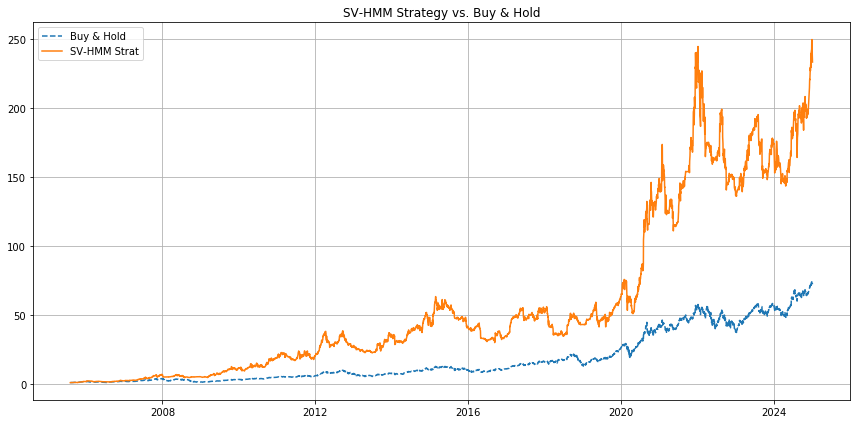

In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

# --- Step 0: reproducible jitter
rng = np.random.default_rng(42)
jitter_scale = 1e-8

# --- Step 1: Download data, compute returns & shifted MA100
data = yf.download('AAPL', start='2004-01-01', end='2025-01-01')
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['MA100']       = data['Close'].shift(1).rolling(100).mean()
data.dropna(inplace=True)

log_returns = data['Log_Returns'].values

# --- Step 2: Parameters
window           = 300
refit_every      = 10
transaction_cost = 0.001   # 0.1% round‑trip cost

# Storage
positions        = []
dates            = []
returns_strategy = []
regimes_rolling  = []

# State carried between refits
current_signal   = 0.0
current_regime   = 1
current_sigma    = 0.0

# --- Step 3: Rolling window, daily P&L
for t in tqdm(range(window, len(data) - 1), desc="Rolling SV‑HMM"):
    # only refit every refit_every days
    if (t - window) % refit_every == 0:
        window_ret = log_returns[t-window:t].reshape(-1,1)
        if np.var(window_ret) < 1e-8:
            # too little variance, skip
            pass
        else:
            try:
                # add tiny noise to avoid degenerate covariances
                wr = window_ret + rng.normal(0, jitter_scale, window_ret.shape)

                # fit HMM
                model = GaussianHMM(n_components=3, covariance_type='full', n_iter=300)
                model.fit(wr)

                # posterior probs
                proba      = model.predict_proba(wr)
                last_proba = proba[-1]

                # reorder by vol
                vols       = [np.trace(cov) for cov in model.covars_]
                order      = np.argsort(vols)
                p_reord    = np.array([ last_proba[i] for i in order ])

                # AR(1) on log‐sq‐returns to forecast sigma per state
                lr2 = np.log(wr.flatten()**2 + 1e-8)
                sigma_states = np.zeros(3)
                for i in range(3):
                    idx = np.where(proba[:,i] > 0.5)[0]
                    if len(idx) >= 5:
                        y  = lr2[idx]
                        x  = y[:-1]; y1 = y[1:]
                        ar = LinearRegression().fit(x.reshape(-1,1), y1)
                        phi = ar.coef_[0]
                        if abs(phi) < 1:
                            mu = ar.intercept_/(1-phi)
                            h  = mu + phi*(y1[-1] - mu)
                            sigma_states[i] = np.exp(h/2)
                        else:
                            sigma_states[i] = np.nan
                    else:
                        sigma_states[i] = np.nan

                valid = ~np.isnan(sigma_states)
                if valid.any():
                    current_sigma = (p_reord[valid]*sigma_states[valid]).sum() / p_reord[valid].sum()

                # trend filter via shifted MA100
                price = float(data['Close'].iloc[t])
                ma100 = float(data['MA100'].iloc[t])
                if price > ma100:
                    lw, sw = 2.0, -0.25
                else:
                    lw, sw = 0.75, -1.0

                # build signal
                hmm_sig        = p_reord[0]*lw + p_reord[2]*sw
                current_signal = 0.5*hmm_sig if current_sigma > 0.03 else hmm_sig
                current_regime = int(np.argmax(p_reord))

            except Exception as e:
                print(f"[t={t} {data.index[t].date()}] HMM fit failed: {e}")
                # keep prior current_signal/regime/sigma

    # apply daily P&L
    r_next = log_returns[t+1]
    cost   = transaction_cost * abs(current_signal - (positions[-1] if positions else 0.0))
    pnl    = current_signal * r_next - cost

    positions.append(current_signal)
    returns_strategy.append(pnl)
    regimes_rolling.append(current_regime)
    dates.append(data.index[t+1])

# --- Step 4: Build results
df_hmm = pd.DataFrame({
    'Date': dates,
    'Position': positions,
    'Return_Strategy': returns_strategy,
    'Regime': regimes_rolling
}).set_index('Date')

df_hmm['Cumulative_Strategy'] = (1 + df_hmm['Return_Strategy']).cumprod()
df_hmm['Cumulative_Market']   = (1 + data['Log_Returns'].loc[df_hmm.index]).cumprod()

# --- Step 5: Metrics
daily    = df_hmm['Return_Strategy']
mean_ann = daily.mean() * 252
vol_ann  = daily.std()  * np.sqrt(252)
sharpe   = mean_ann / vol_ann

print("SV‑HMM Approx. with daily P&L & costs")
print(f"Annual Return    = {mean_ann:.2%}")
print(f"Annual Volatility= {vol_ann:.2%}")
print(f"Sharpe Ratio     = {sharpe:.2f}")
print(f"Last σ forecast  = {current_sigma:.4f}")

# --- Step 6: Plot
plt.figure(figsize=(12,6))
plt.plot(df_hmm.index, df_hmm['Cumulative_Market'],   '--', label='Buy & Hold')
plt.plot(df_hmm.index, df_hmm['Cumulative_Strategy'],  label='SV‑HMM Strat')
plt.legend(); plt.title("SV‑HMM Strategy vs. Buy & Hold")
plt.grid(True); plt.tight_layout()
plt.show()
